# Libraries

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.calibration import calibration_curve

from sklearn.metrics import (
    roc_auc_score, balanced_accuracy_score, 
    confusion_matrix, precision_score, recall_score, log_loss, brier_score_loss, balanced_accuracy_score, f1_score
)

from scipy.stats import ks_2samp

from mapie.metrics.calibration import expected_calibration_error

# Helper Functions

In [2]:
# Model Metric
def model_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)

    metrics = {
        "ROC_AUC": round(roc_auc_score(y_true, y_prob), 3),
        "Balanced_Accuracy": round(balanced_accuracy_score(y_true, y_pred), 3),
        "Precision": round(precision_score(y_true, y_pred, zero_division=0), 3),
        "Recall": round(recall_score(y_true, y_pred, zero_division=0), 3),
        "F1": round(f1_score(y_true, y_pred, zero_division=0), 3),
        "LogLoss": round(log_loss(y_true, y_prob), 3),
    }

    return metrics


def get_model_performance(df, additional_prob=None):
    model_perf = pd.DataFrame()

    for nodes in ['lr', 'xgb']:
        for models in ['raw_prob', 'platt_prob', 'iso_prob', 'venn_ivap', 'venn_cvap']:
            performance = model_metrics(df['loan_status'], df[f'{nodes}_{models}'], threshold=0.17)
            performance['method_name'] = f'{nodes}_{models}'
            performance = pd.DataFrame([performance])
            model_perf = pd.concat([model_perf, performance], ignore_index=True)

    if additional_prob is not None:
        performance = model_metrics(df['loan_status'], df[additional_prob], threshold=0.17)
        performance['method_name'] = additional_prob
        performance = pd.DataFrame([performance])
        model_perf = pd.concat([model_perf, performance], ignore_index=True)

    return model_perf


#######################################################

# Calibration Metrics
def calibration_metrics(y_true, y_proba, method_name, split_strategy='uniform'):
    logloss = round(log_loss(y_true, y_proba),3)
    brier   = round(brier_score_loss(y_true, y_proba),3)
    ece = round(expected_calibration_error(y_true, y_proba, num_bins=10, split_strategy=split_strategy),3)
    return {"Method": method_name, "Log Loss": logloss, "Brier Score": brier, "ECE": ece}

def get_calibration_performance(df, split_strategy='quantile', additional_prob=None):
    calib_perf = pd.DataFrame()

    for nodes in ['lr', 'xgb']:
        for models in ['raw_prob', 'platt_prob', 'iso_prob', 'venn_ivap', 'venn_cvap']:
            performance = calibration_metrics(df['loan_status'], df[f'{nodes}_{models}'], method_name=f'{nodes}_{models}', split_strategy=split_strategy)
            performance = pd.DataFrame([performance])
            calib_perf = pd.concat([calib_perf, performance], ignore_index=True)

    if additional_prob is not None:
        performance = calibration_metrics(df['loan_status'], df[additional_prob], method_name=additional_prob, split_strategy=split_strategy)
        performance = pd.DataFrame([performance])
        calib_perf = pd.concat([calib_perf, performance], ignore_index=True)

    return calib_perf

In [ ]:
def model_performance_plot(df, prob_name, model_name, set):

    train = df.copy()
    train['bin'] = pd.qcut(train[prob_name], q=10, labels=False, duplicates='drop')

    train_grp = train.groupby('bin').agg(
        count=('loan_status', 'size'),
        pos=('loan_status', 'sum'),
        neg=('loan_status', lambda x: (x == 0).sum())
    ).reset_index()


    train_grp['% pos'] = round(train_grp['pos'] / train_grp['count'] * 100,1)
    train_grp['% dist pos'] = round(train_grp['pos'] / train_grp['pos'].sum() * 100,1)
    train_grp['% dist neg'] = round(train_grp['neg'] / train_grp['neg'].sum() * 100,1)

    # Width of each bar
    bar_width = 0.35

    # Create figure and axis objects
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot mean values on the first y-axis
    ax1.plot(train_grp['bin'], train_grp['% pos'],'--o', color='gray', label='Default Rate')
    ax1.set_xlabel('Riskiness')
    ax1.set_ylabel('% Default Rate', color='gray')
    ax1.tick_params('y', colors='gray')

    # Create a second y-axis sharing the same x-axis
    ax2 = ax1.twinx()

    # Plot sum and count values on the second y-axis as separate bars
    index = np.arange(len(train_grp['bin']))
    ax2.set_xticks(index)
    ax2.bar(index - bar_width/2, train_grp['% dist neg'], bar_width, color='lightcoral', alpha=0.5, label='Non-Default')
    ax2.bar(index + bar_width/2, train_grp['% dist pos'], bar_width, color='olivedrab', alpha=0.5, label='Default')
    ax2.set_ylabel('%N of Default and Non-Default', color='lightcoral')
    ax2.tick_params('y', colors='lightcoral')

    # Rotate x-axis tick labels

    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    # Show plot
    plt.title(f'**{model_name}** Default and Non-Default Distribution ({set} Set)')
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

    return train_grp

In [4]:
def plot_ks_and_cdf(df, prob_col, label='Raw Probability', model_name='Model'):
    # Split probabilities by class
    prob_0 = df[df['loan_status'] == 0][prob_col]
    prob_1 = df[df['loan_status'] == 1][prob_col]

    # KS statistic
    ks_stat, ks_p = ks_2samp(prob_0, prob_1)
    print(f"KS Statistic ({model_name}): {ks_stat:.4f}, p-value: {ks_p:.4g}")

    # Plot PDFs (histograms)
    plt.figure(figsize=(14, 6)) # Adjusted figure size for better layout
    plt.subplot(1, 2, 1)
    plt.hist(prob_0, bins=50, alpha=0.6, label='Non-Default (0)', density=True, color='skyblue')
    plt.hist(prob_1, bins=50, alpha=0.6, label='Default (1)', density=True, color='salmon')
    plt.title(f'{model_name} - PDF {label}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.legend()

    # Plot CDFs
    plt.subplot(1, 2, 2)
    prob_0_sorted = np.sort(prob_0)
    prob_1_sorted = np.sort(prob_1)
    cdf_0 = np.arange(1, len(prob_0_sorted)+1) / len(prob_0_sorted)
    cdf_1 = np.arange(1, len(prob_1_sorted)+1) / len(prob_1_sorted)
    plt.plot(prob_0_sorted, cdf_0, label='Non-Default (0)', color='skyblue')
    plt.plot(prob_1_sorted, cdf_1, label='Default (1)', color='salmon')
    
    # --- START OF CORRECTED SECTION ---
    
    # Find the probability (x-value) where the maximum difference occurs
    all_probs = np.unique(np.concatenate([prob_0, prob_1]))
    cdf_0_vals = np.array([np.mean(prob_0 <= x) for x in all_probs])
    cdf_1_vals = np.array([np.mean(prob_1 <= x) for x in all_probs])
    diffs = np.abs(cdf_0_vals - cdf_1_vals)
    
    # Get the location and values for the KS line
    max_diff_idx = np.argmax(diffs)
    ks_location = all_probs[max_diff_idx]
    cdf_0_at_ks = cdf_0_vals[max_diff_idx]
    cdf_1_at_ks = cdf_1_vals[max_diff_idx]

    # Plot the vertical line at the correct location
    plt.axvline(x=ks_location, color='gray', linestyle='--', label=f'KS location: {ks_location:.4f}')
    
    # Plot the vertical line segment representing the KS statistic
    plt.plot([ks_location, ks_location], [cdf_0_at_ks, cdf_1_at_ks], 
             color='black', linewidth=2, label=f'KS Statistic: {ks_stat:.4f}')
             

    plt.title(f'{model_name} - CDF {label}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    # plt.grid(True)

    plt.tight_layout()
    plt.show()

    return ks_stat, ks_p

# Import Data

`XGBoost`

In [5]:
xgb_train = pd.read_csv("Results/prob_tr_xgb.csv", low_memory=False)
xgb_valid = pd.read_csv("Results/prob_val_xgb.csv", low_memory=False)
xgb_test = pd.read_csv("Results/prob_test_xgb.csv", low_memory=False)

In [6]:
xgb_train.columns

Index(['ID', 'Raw (Uncalibrated)', 'Platt Scaling', 'Isotonic Regression',
       'Venn-Abers (IVAP)', 'P0 (IVAP)', 'P1 (IVAP)', 'Venn-Abers (CVAP)',
       'Mean P0 (CVAP)', 'Mean P1 (CVAP)', 'Min P0 (CVAP)', 'Max P1 (CVAP)',
       'loan_status'],
      dtype='object')

In [7]:
xgb_train.rename(columns={'Raw (Uncalibrated)': 'xgb_raw_prob', 'Platt Scaling': 'xgb_platt_prob', 'Isotonic Regression': 'xgb_iso_prob',
                          'Venn-Abers (IVAP)': 'xgb_venn_ivap', 'P0 (IVAP)': 'xgb_p0_ivap', 'P1 (IVAP)': 'xgb_p1_ivap',
                          'Venn-Abers (CVAP)': 'xgb_venn_cvap', 'Mean P0 (CVAP)': 'xgb_mean_p0_cvap', 'Mean P1 (CVAP)': 'xgb_mean_p1_cvap',
                          'Min P0 (CVAP)': 'xgb_min_p0_cvap', 'Max P1 (CVAP)': 'xgb_max_p1_cvap'}, inplace=True)

xgb_valid.rename(columns={'Raw (Uncalibrated)': 'xgb_raw_prob', 'Platt Scaling': 'xgb_platt_prob', 'Isotonic Regression': 'xgb_iso_prob',
                          'Venn-Abers (IVAP)': 'xgb_venn_ivap', 'P0 (IVAP)': 'xgb_p0_ivap', 'P1 (IVAP)': 'xgb_p1_ivap',
                          'Venn-Abers (CVAP)': 'xgb_venn_cvap', 'Mean P0 (CVAP)': 'xgb_mean_p0_cvap', 'Mean P1 (CVAP)': 'xgb_mean_p1_cvap',
                          'Min P0 (CVAP)': 'xgb_min_p0_cvap', 'Max P1 (CVAP)': 'xgb_max_p1_cvap'}, inplace=True)

xgb_test.rename(columns={'Raw (Uncalibrated)': 'xgb_raw_prob', 'Platt Scaling': 'xgb_platt_prob', 'Isotonic Regression': 'xgb_iso_prob',
                          'Venn-Abers (IVAP)': 'xgb_venn_ivap', 'P0 (IVAP)': 'xgb_p0_ivap', 'P1 (IVAP)': 'xgb_p1_ivap',
                          'Venn-Abers (CVAP)': 'xgb_venn_cvap', 'Mean P0 (CVAP)': 'xgb_mean_p0_cvap', 'Mean P1 (CVAP)': 'xgb_mean_p1_cvap',
                          'Min P0 (CVAP)': 'xgb_min_p0_cvap', 'Max P1 (CVAP)': 'xgb_max_p1_cvap'}, inplace=True)

In [8]:
xgb_train.head()

,ID,xgb_raw_prob,xgb_platt_prob,xgb_iso_prob,xgb_venn_ivap,xgb_p0_ivap,xgb_p1_ivap,xgb_venn_cvap,xgb_mean_p0_cvap,xgb_mean_p1_cvap,xgb_min_p0_cvap,xgb_max_p1_cvap,loan_status
0,23482,0.056485,0.045133,0.044118,0.046784,0.043988,0.046921,0.054905,0.052685,0.055391,0.042899,0.061303,0
1,14094,0.926562,0.992440,0.982456,0.958497,0.957447,0.982759,0.935486,0.924778,0.992217,0.894737,1.000000,1
2,3966,0.045211,0.040906,0.023256,0.024956,0.023224,0.025000,0.029949,0.029739,0.031718,0.015089,0.043421,0
3,5052,0.004552,0.028603,0.000000,0.001161,0.000000,0.001163,0.002254,0.000000,0.002332,0.000000,0.003289,0
4,25312,0.135356,0.088411,0.114458,0.116000,0.114228,0.116232,0.132353,0.126123,0.133961,0.111675,0.148148,0


In [9]:
xgb_train.shape, xgb_valid.shape, xgb_test.shape

((20745, 13), (5187, 13), (6484, 13))

`Logistic Regression`

In [10]:
lr_train = pd.read_csv("Results/prob_tr_lr.csv", low_memory=False)
lr_valid = pd.read_csv("Results/prob_val_lr.csv", low_memory=False)
lr_test = pd.read_csv("Results/prob_test_lr.csv", low_memory=False)

In [11]:
lr_train.columns

Index(['ID', 'loan_status', 'raw_score', 'platt_score', 'isotonic_score',
       'venn_abers_ind_', 'p0_va_ind', 'p1_va_ind', 'venn_abers_cross_score',
       'mean_p0_va_cross', 'mean_p1_va_cross', 'min_p0_va_cross',
       'max_p1_va_cross'],
      dtype='object')

In [12]:
lr_train.rename(columns={'raw_score': 'lr_raw_prob', 'platt_score' : 'lr_platt_prob', 'isotonic_score': 'lr_iso_prob',
                          'venn_abers_ind_': 'lr_venn_ivap', 'p0_va_ind': 'lr_p0_ivap', 'p1_va_ind': 'lr_p1_ivap',
                          'venn_abers_cross_score': 'lr_venn_cvap', 'mean_p0_va_cross': 'lr_mean_p0_cvap',
                          'mean_p1_va_cross': 'lr_mean_p1_cvap', 'min_p0_va_cross': 'lr_min_p0_cvap',
                          'max_p1_va_cross': 'lr_max_p1_cvap'}, inplace=True)

lr_valid.rename(columns={'raw_score': 'lr_raw_prob', 'platt_score' : 'lr_platt_prob', 'isotonic_score': 'lr_iso_prob',
                         'venn_abers_ind_': 'lr_venn_ivap', 'p0_va_ind': 'lr_p0_ivap', 'p1_va_ind': 'lr_p1_ivap',
                         'venn_abers_cross_score': 'lr_venn_cvap', 'mean_p0_va_cross': 'lr_mean_p0_cvap',
                         'mean_p1_va_cross': 'lr_mean_p1_cvap', 'min_p0_va_cross': 'lr_min_p0_cvap',
                         'max_p1_va_cross': 'lr_max_p1_cvap'}, inplace=True)

lr_test.rename(columns={'raw_score': 'lr_raw_prob', 'platt_score' : 'lr_platt_prob', 'isotonic_score': 'lr_iso_prob',
                        'venn_abers_ind_': 'lr_venn_ivap', 'p0_va_ind': 'lr_p0_ivap', 'p1_va_ind': 'lr_p1_ivap',
                        'venn_abers_cross_score': 'lr_venn_cvap', 'mean_p0_va_cross': 'lr_mean_p0_cvap',
                        'mean_p1_va_cross': 'lr_mean_p1_cvap', 'min_p0_va_cross': 'lr_min_p0_cvap',
                        'max_p1_va_cross': 'lr_max_p1_cvap'}, inplace=True)

In [13]:
lr_train.head()

,ID,loan_status,lr_raw_prob,lr_platt_prob,lr_iso_prob,lr_venn_ivap,lr_p0_ivap,lr_p1_ivap,lr_venn_cvap,lr_mean_p0_cvap,lr_mean_p1_cvap,lr_min_p0_cvap,lr_max_p1_cvap
0,23482,0,0.252648,0.241808,0.208617,0.209932,0.208145,0.210407,0.233744,0.230901,0.235104,0.207483,0.252336
1,14094,1,0.404910,0.399293,0.398148,0.400000,0.394495,0.403670,0.400795,0.398299,0.403205,0.356495,0.459302
2,3966,0,0.054387,0.047321,0.053407,0.054612,0.053309,0.054688,0.064863,0.062790,0.065481,0.053806,0.080000
3,5052,0,0.018817,0.015438,0.023392,0.028289,0.023256,0.028436,0.025443,0.022719,0.026283,0.019093,0.040000
4,25312,0,0.492863,0.491469,0.526718,0.526378,0.522727,0.530435,0.501241,0.492394,0.510195,0.462366,0.532258


In [14]:
lr_train.shape, lr_valid.shape, lr_test.shape

((20745, 13), (5187, 13), (6484, 13))

`Bootstrap`

In [15]:
boot_valid = pd.read_csv("Bootstrap/Results/valid_set_prediction_intervals.csv", low_memory=False)
boot_test = pd.read_csv("Bootstrap/Results/test_set_prediction_intervals.csv", low_memory=False)

In [16]:
boot_valid.rename(columns={
    'lower_bound': 'boot_lower_bound',
    'upper_bound': 'boot_upper_bound',
    'mean_prob' : 'boot_mean_prob'
}, inplace=True)


boot_test.rename(columns={
    'lower_bound': 'boot_lower_bound',
    'upper_bound': 'boot_upper_bound',
    'mean_prob' : 'boot_mean_prob' 
}, inplace=True)


In [17]:
boot_valid.head()

,ID,boot_lower_bound,boot_upper_bound,boot_mean_prob
0,8,0.522576,0.721351,0.618446
1,14,0.519430,0.685991,0.594978
2,15,0.051608,0.077225,0.063505
3,18,0.658788,0.807439,0.742029
4,21,0.016116,0.038583,0.024165


`Combination`

In [18]:
train = xgb_train.merge(lr_train, on=['ID', 'loan_status'])
valid = xgb_valid.merge(lr_valid, on=['ID', 'loan_status']).merge(boot_valid, on=['ID'])
test = xgb_test.merge(lr_test, on=['ID', 'loan_status']).merge(boot_test, on=['ID'])

In [19]:
train.shape, valid.shape, test.shape

((20745, 24), (5187, 27), (6484, 27))

# Performance

## `Model Metrics`

In [20]:
print('XGBoost')
model_metrics(train['loan_status'], train['xgb_raw_prob'], threshold=0.17)

XGBoost


{'ROC_AUC': 0.956,
 'Balanced_Accuracy': 0.885,
 'Precision': 0.737,
 'Recall': 0.856,
 'F1': 0.792,
 'LogLoss': 0.187}

In [21]:
print('Logistic Regression')
model_metrics(train['loan_status'], train['lr_raw_prob'], threshold=0.17)

Logistic Regression


{'ROC_AUC': 0.857,
 'Balanced_Accuracy': 0.771,
 'Precision': 0.451,
 'Recall': 0.826,
 'F1': 0.583,
 'LogLoss': 0.359}

In [22]:
valid.head()

,ID,xgb_raw_prob,xgb_platt_prob,xgb_iso_prob,xgb_venn_ivap,xgb_p0_ivap,xgb_p1_ivap,xgb_venn_cvap,xgb_mean_p0_cvap,xgb_mean_p1_cvap,...,lr_p0_ivap,lr_p1_ivap,lr_venn_cvap,lr_mean_p0_cvap,lr_mean_p1_cvap,lr_min_p0_cvap,lr_max_p1_cvap,boot_lower_bound,boot_upper_bound,boot_mean_prob
0,8881,0.412257,0.547426,0.655172,0.571429,0.500000,0.666667,0.599018,0.556477,0.652263,...,0.208145,0.210407,0.264590,0.257335,0.269181,0.211823,0.307692,0.232438,0.391443,0.292649
1,22262,0.097211,0.064115,0.101266,0.107867,0.101010,0.108696,0.106692,0.100109,0.108131,...,0.538462,0.574324,0.515650,0.508582,0.522907,0.465116,0.563830,0.429534,0.578584,0.519704
2,10162,0.140037,0.091911,0.118421,0.123377,0.117647,0.124183,0.154612,0.151777,0.155471,...,0.573529,0.588235,0.568542,0.564401,0.573573,0.520231,0.600000,0.527208,0.643259,0.581138
3,32333,0.058661,0.045996,0.044118,0.049366,0.043988,0.049645,0.038480,0.034587,0.040604,...,0.065517,0.068966,0.080727,0.078374,0.081135,0.068027,0.085399,0.060168,0.102160,0.078981
4,14369,0.003259,0.028277,0.000000,0.000973,0.000000,0.000974,0.001840,0.000000,0.001888,...,0.000000,0.012658,0.013905,0.001695,0.014654,0.000000,0.020408,0.000000,0.012000,0.002338


In [23]:
model_perf_train = get_model_performance(train)
model_perf_valid = get_model_performance(valid, additional_prob='boot_mean_prob')
model_perf_test = get_model_performance(test, additional_prob='boot_mean_prob')

In [24]:
model_perf_train.sort_values(
    by=['ROC_AUC', 'LogLoss'],
    ascending=[False, True]
)

,ROC_AUC,Balanced_Accuracy,Precision,Recall,F1,LogLoss,method_name
8,0.956,0.885,0.811,0.825,0.818,0.182,xgb_venn_ivap
5,0.956,0.885,0.737,0.856,0.792,0.187,xgb_raw_prob
6,0.956,0.885,0.843,0.813,0.828,0.189,xgb_platt_prob
7,0.956,0.885,0.834,0.816,0.825,0.194,xgb_iso_prob
9,0.952,0.877,0.689,0.865,0.767,0.187,xgb_venn_cvap
4,0.857,0.776,0.473,0.806,0.596,0.357,lr_venn_cvap
0,0.857,0.771,0.451,0.826,0.583,0.359,lr_raw_prob
1,0.857,0.774,0.463,0.814,0.591,0.360,lr_platt_prob
3,0.856,0.778,0.479,0.802,0.600,0.359,lr_venn_ivap
2,0.856,0.781,0.502,0.780,0.611,0.367,lr_iso_prob


In [25]:
model_perf_valid.sort_values(
    by=['ROC_AUC', 'LogLoss'],
    ascending=[False, True]
)

,ROC_AUC,Balanced_Accuracy,Precision,Recall,F1,LogLoss,method_name
9,0.959,0.885,0.699,0.873,0.776,0.172,xgb_venn_cvap
7,0.944,0.871,0.815,0.790,0.803,0.183,xgb_iso_prob
8,0.943,0.869,0.792,0.796,0.794,0.186,xgb_venn_ivap
5,0.942,0.864,0.708,0.819,0.760,0.194,xgb_raw_prob
6,0.942,0.869,0.819,0.786,0.802,0.198,xgb_platt_prob
2,0.871,0.789,0.497,0.797,0.612,0.337,lr_iso_prob
3,0.870,0.785,0.472,0.818,0.599,0.339,lr_venn_ivap
10,0.869,0.785,0.473,0.818,0.600,0.341,boot_mean_prob
4,0.868,0.784,0.467,0.822,0.595,0.343,lr_venn_cvap
1,0.868,0.781,0.456,0.831,0.589,0.344,lr_platt_prob


In [26]:
model_perf_test.sort_values(
    by=['ROC_AUC', 'LogLoss'],
    ascending=[False, True]
)

,ROC_AUC,Balanced_Accuracy,Precision,Recall,F1,LogLoss,method_name
9,0.938,0.861,0.665,0.840,0.742,0.199,xgb_venn_cvap
8,0.938,0.865,0.793,0.787,0.790,0.201,xgb_venn_ivap
5,0.938,0.864,0.716,0.818,0.763,0.203,xgb_raw_prob
6,0.938,0.866,0.817,0.781,0.799,0.207,xgb_platt_prob
7,0.937,0.866,0.811,0.782,0.796,0.267,xgb_iso_prob
4,0.859,0.785,0.482,0.814,0.605,0.354,lr_venn_cvap
10,0.859,0.785,0.489,0.803,0.608,0.359,boot_mean_prob
0,0.858,0.777,0.455,0.830,0.588,0.357,lr_raw_prob
1,0.858,0.780,0.468,0.819,0.596,0.357,lr_platt_prob
3,0.857,0.785,0.488,0.804,0.608,0.356,lr_venn_ivap


### *Gini Plot*

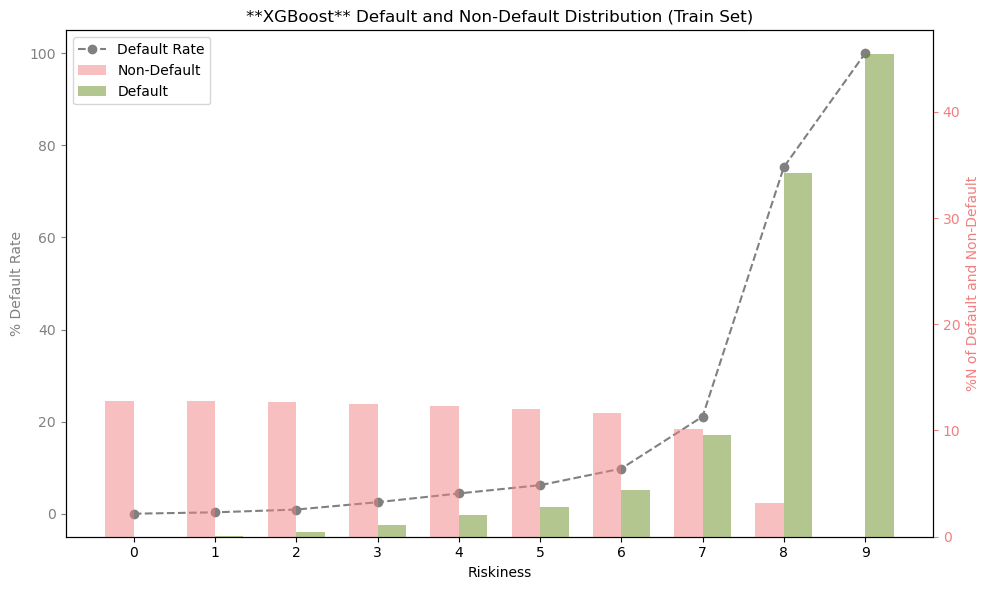

,bin,count,pos,neg,% pos,% dist pos,% dist neg
0,0,2078,0,2078,0.0,0.0,12.8
1,1,2071,6,2065,0.3,0.1,12.8
2,2,2076,18,2058,0.9,0.4,12.7
3,3,2073,52,2021,2.5,1.1,12.5
4,4,2075,91,1984,4.4,2.0,12.3
5,5,2074,128,1946,6.2,2.8,12.0
6,6,2074,203,1871,9.8,4.4,11.6
7,7,2075,437,1638,21.1,9.6,10.1
8,8,2074,1561,513,75.3,34.2,3.2
9,9,2075,2075,0,100.0,45.4,0.0


In [27]:
model_performance_plot(df=train, prob_name='xgb_raw_prob', model_name='XGBoost', set='Train')

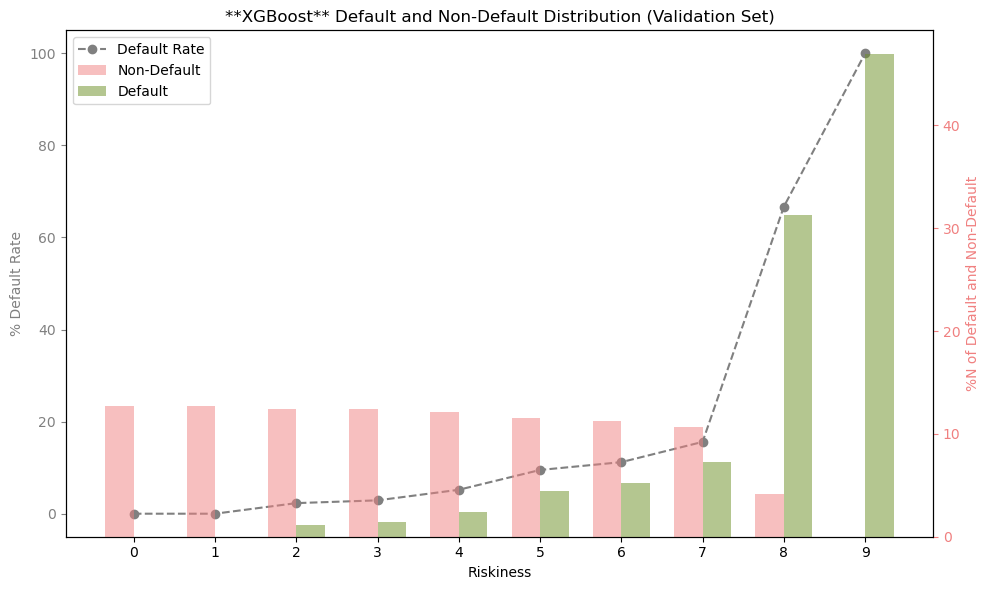

,bin,count,pos,neg,% pos,% dist pos,% dist neg
0,0,519,0,519,0.0,0.0,12.7
1,1,519,0,519,0.0,0.0,12.7
2,2,518,12,506,2.3,1.1,12.4
3,3,519,15,504,2.9,1.4,12.4
4,4,519,27,492,5.2,2.4,12.1
5,5,518,49,469,9.5,4.4,11.5
6,6,519,58,461,11.2,5.2,11.3
7,7,518,81,437,15.6,7.3,10.7
8,8,519,346,173,66.7,31.3,4.2
9,9,519,519,0,100.0,46.9,0.0


In [28]:
model_performance_plot(df=valid, prob_name='xgb_raw_prob', model_name='XGBoost', set='Validation')

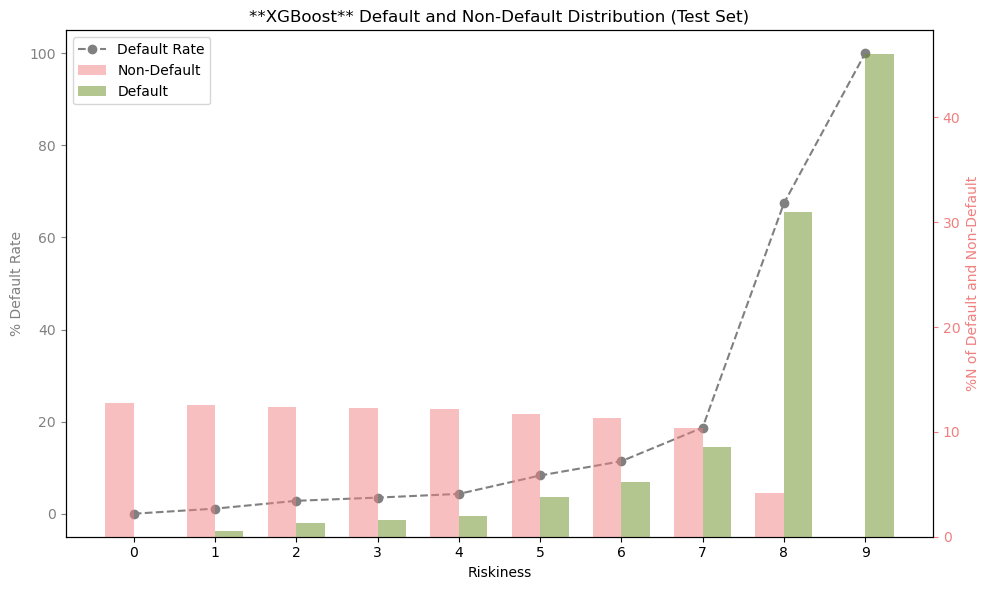

,bin,count,pos,neg,% pos,% dist pos,% dist neg
0,0,649,0,649,0.0,0.0,12.8
1,1,648,7,641,1.1,0.5,12.6
2,2,649,18,631,2.8,1.3,12.4
3,3,648,23,625,3.5,1.6,12.3
4,4,648,28,620,4.3,2.0,12.2
5,5,648,54,594,8.3,3.8,11.7
6,6,649,74,575,11.4,5.2,11.3
7,7,648,121,527,18.7,8.6,10.4
8,8,648,437,211,67.4,31.0,4.2
9,9,649,649,0,100.0,46.0,0.0


In [29]:
model_performance_plot(df=test, prob_name='xgb_raw_prob', model_name='XGBoost', set='Test')

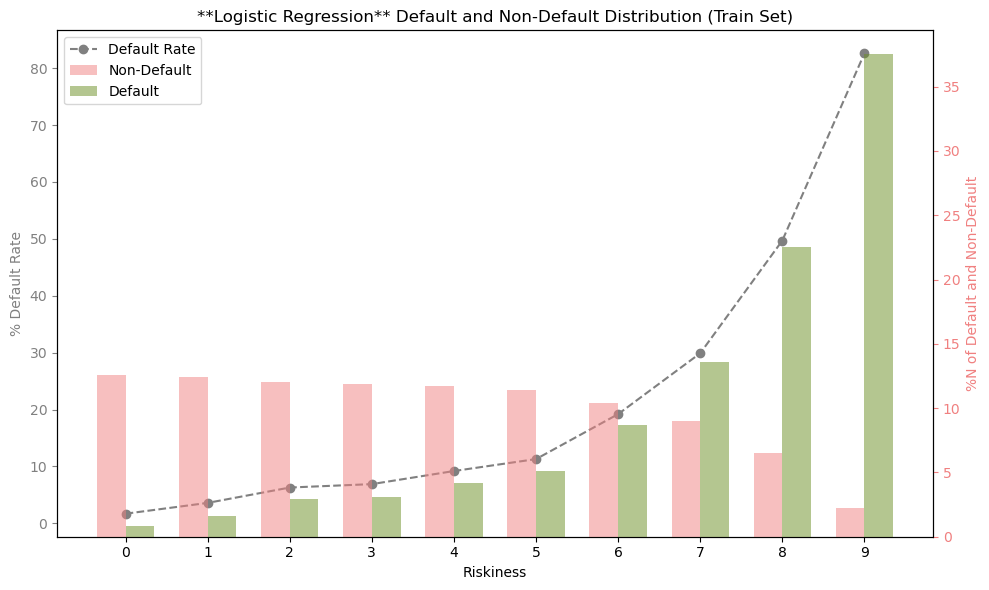

,bin,count,pos,neg,% pos,% dist pos,% dist neg
0,0,2075,36,2039,1.7,0.8,12.6
1,1,2074,74,2000,3.6,1.6,12.4
2,2,2075,131,1944,6.3,2.9,12.0
3,3,2074,143,1931,6.9,3.1,11.9
4,4,2075,190,1885,9.2,4.2,11.7
5,5,2074,234,1840,11.3,5.1,11.4
6,6,2074,399,1675,19.2,8.7,10.4
7,7,2075,621,1454,29.9,13.6,9.0
8,8,2074,1030,1044,49.7,22.5,6.5
9,9,2075,1713,362,82.6,37.5,2.2


In [30]:
model_performance_plot(df=train, prob_name='lr_raw_prob', model_name='Logistic Regression', set='Train')

### *kolmogorov_smirnov_test and CDFs*

KS Statistic (Logistic Regression): 0.5629, p-value: 0


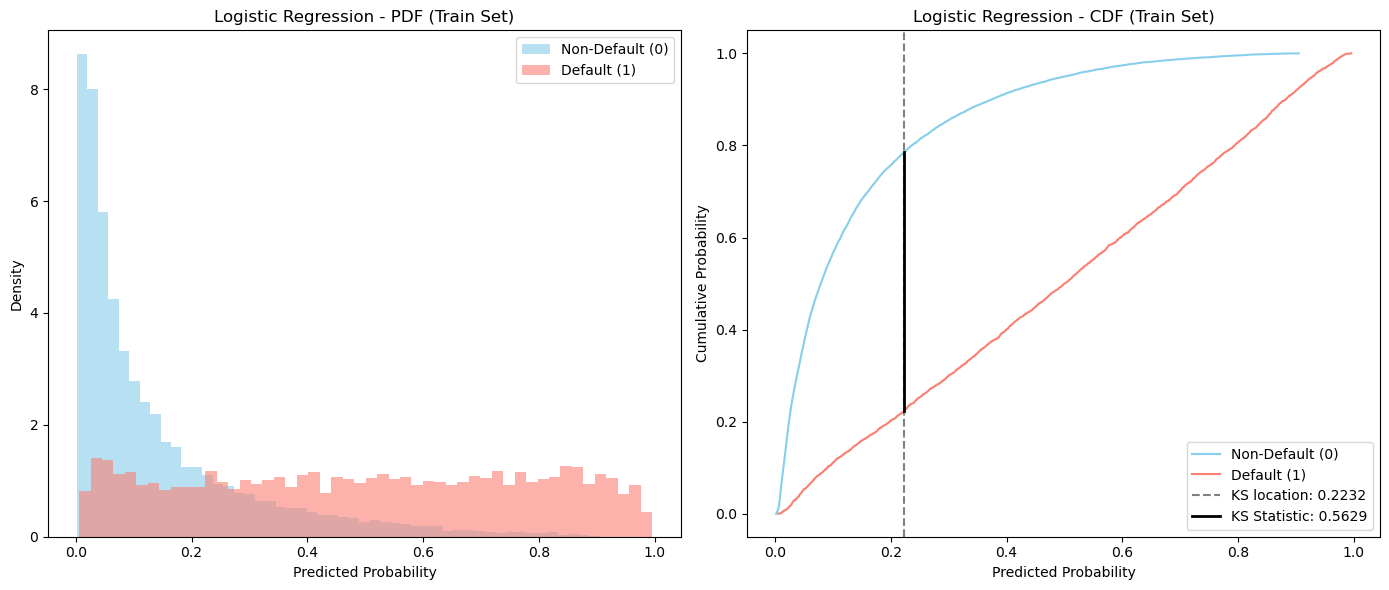

KS Statistic (Logistic Regression): 0.5832, p-value: 4.703e-277


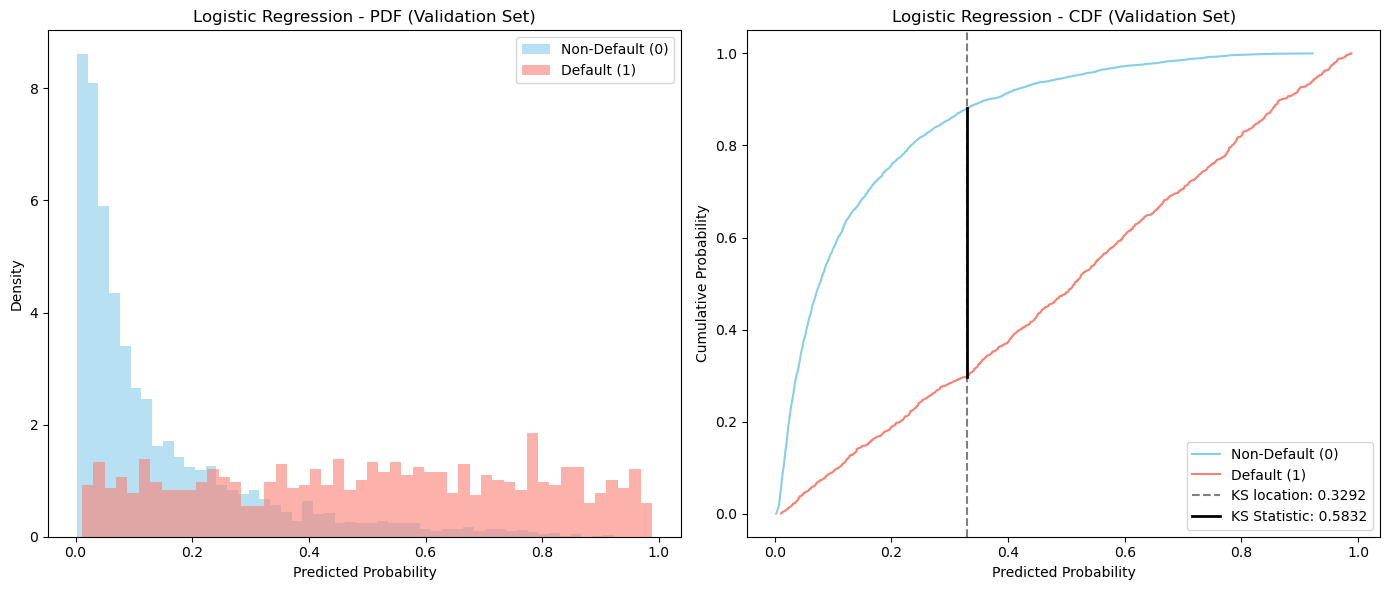

KS Statistic (Logistic Regression): 0.5831, p-value: 3.34e-321


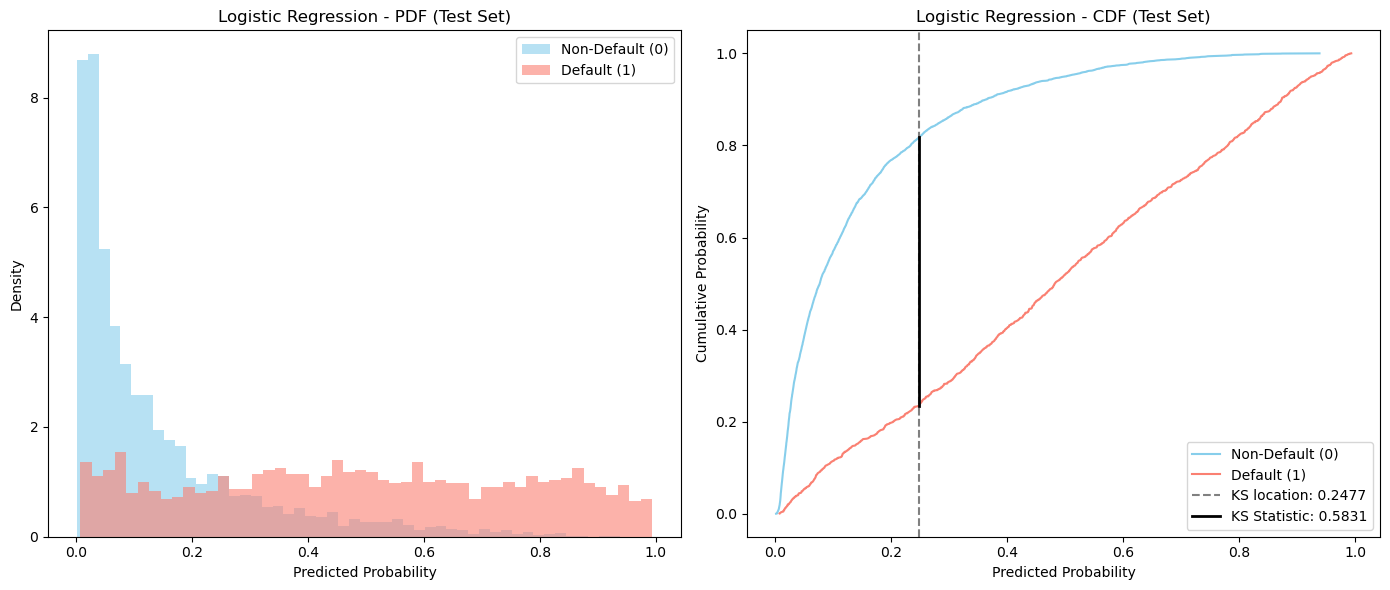

(0.5830767324350101, 3.34e-321)

In [31]:
# Logistic Regression on train set
plot_ks_and_cdf(train, 'lr_raw_prob', label='(Train Set)', model_name='Logistic Regression')

# Logistic Regression on validation set
plot_ks_and_cdf(valid, 'lr_raw_prob', label='(Validation Set)', model_name='Logistic Regression')

# Logistic Regression on test set
plot_ks_and_cdf(test, 'lr_raw_prob', label='(Test Set)', model_name='Logistic Regression')

KS Statistic (XGBoost): 0.7732, p-value: 0


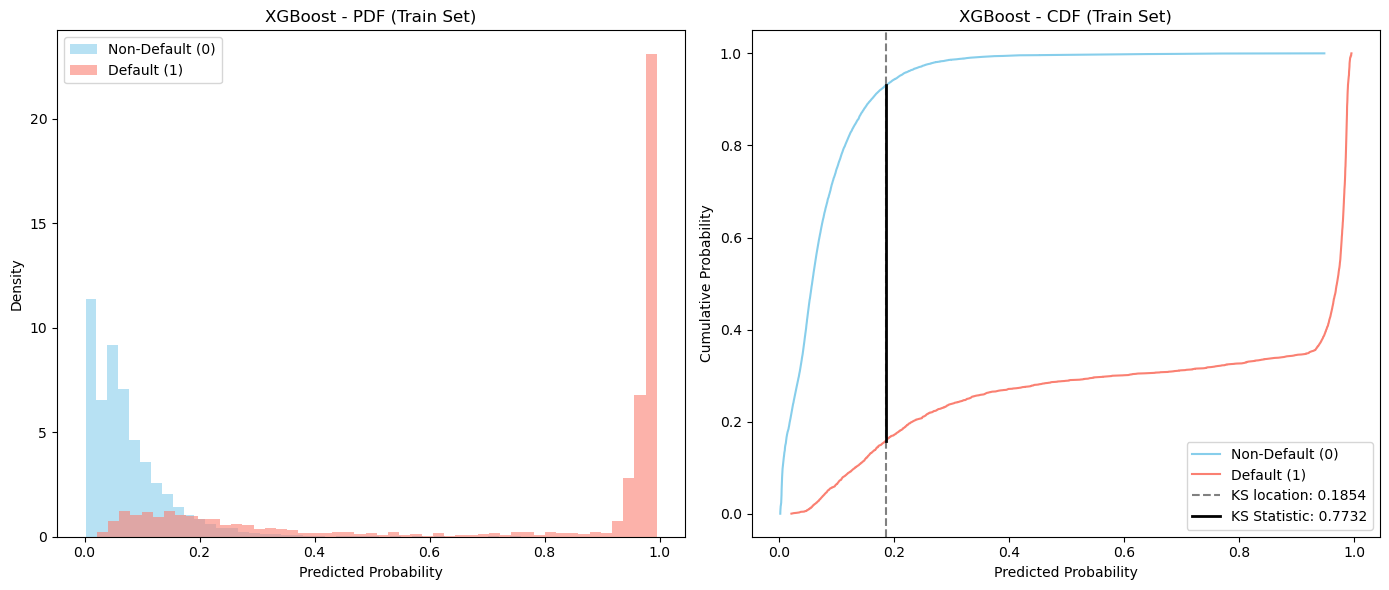

KS Statistic (XGBoost): 0.7419, p-value: 1.191e-321


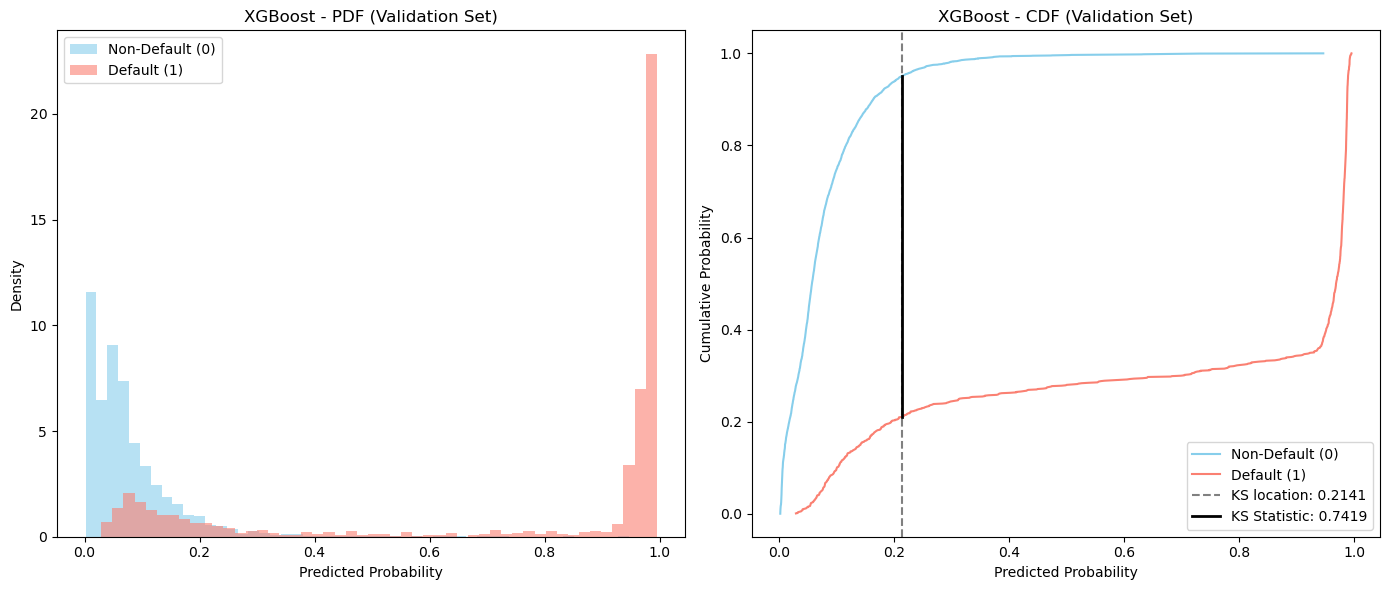

KS Statistic (XGBoost): 0.7333, p-value: 1.369e-321


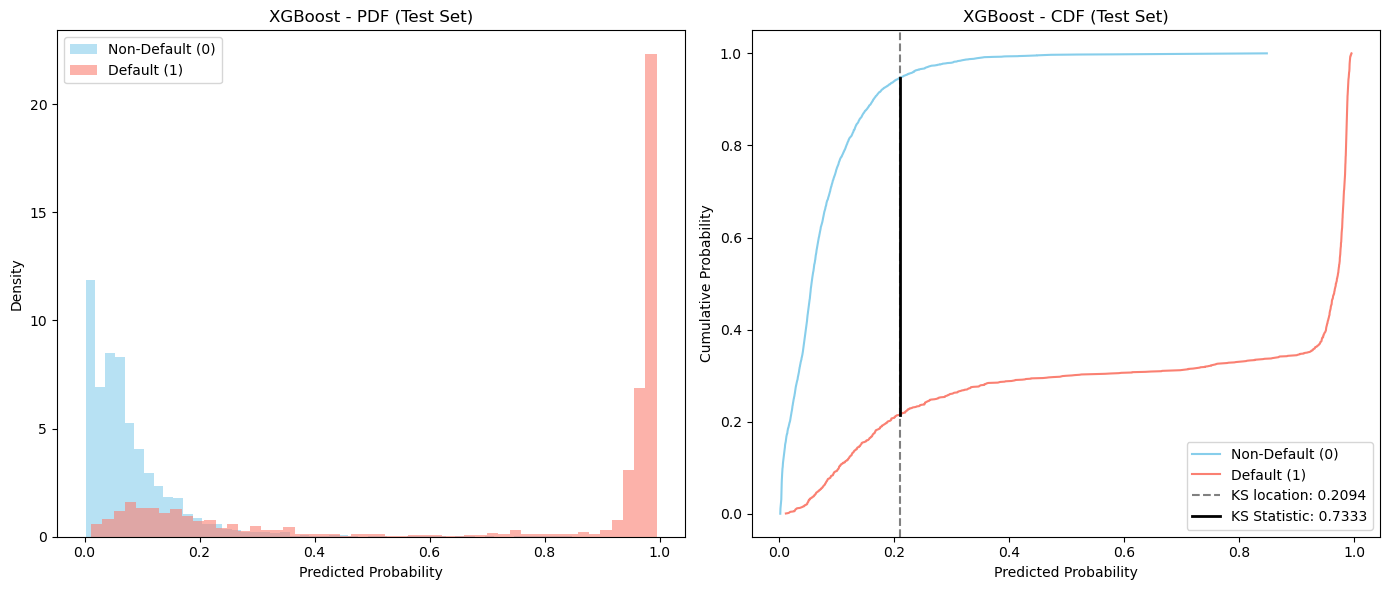

(0.7333358200604275, 1.37e-321)

In [32]:
# XGBoost on train set
plot_ks_and_cdf(train, 'xgb_raw_prob', label='(Train Set)', model_name='XGBoost')

# XGBoost on validation set
plot_ks_and_cdf(valid, 'xgb_raw_prob', label='(Validation Set)', model_name='XGBoost')

# XGBoost on test set
plot_ks_and_cdf(test, 'xgb_raw_prob', label='(Test Set)', model_name='XGBoost')

## `Calibration`

### *Performance*

In [33]:
calibration_perf_train = get_calibration_performance(train, split_strategy='quantile')
calibration_perf_valid = get_calibration_performance(valid, split_strategy='quantile', additional_prob='boot_mean_prob')
calibration_perf_test = get_calibration_performance(test, split_strategy='quantile', additional_prob='boot_mean_prob')

In [34]:
calibration_perf_train.sort_values(by=['ECE', 'Log Loss', 'Brier Score'], ascending=True)

,Method,Log Loss,Brier Score,ECE
4,lr_venn_cvap,0.357,0.110,0.004
3,lr_venn_ivap,0.359,0.110,0.013
2,lr_iso_prob,0.367,0.110,0.014
1,lr_platt_prob,0.360,0.110,0.015
9,xgb_venn_cvap,0.187,0.053,0.017
0,lr_raw_prob,0.359,0.110,0.017
7,xgb_iso_prob,0.194,0.052,0.019
8,xgb_venn_ivap,0.182,0.052,0.021
6,xgb_platt_prob,0.189,0.052,0.026
5,xgb_raw_prob,0.187,0.052,0.027


In [35]:
calibration_perf_valid.sort_values(by=['ECE', 'Log Loss', 'Brier Score'], ascending=True)

,Method,Log Loss,Brier Score,ECE
7,xgb_iso_prob,0.183,0.052,0.000
2,lr_iso_prob,0.337,0.104,0.000
8,xgb_venn_ivap,0.186,0.052,0.004
3,lr_venn_ivap,0.339,0.104,0.005
10,boot_mean_prob,0.341,0.105,0.009
4,lr_venn_cvap,0.343,0.105,0.012
5,xgb_raw_prob,0.194,0.053,0.015
1,lr_platt_prob,0.344,0.105,0.016
0,lr_raw_prob,0.345,0.106,0.017
9,xgb_venn_cvap,0.172,0.048,0.019


In [36]:
calibration_perf_test.sort_values(by=['ECE', 'Log Loss', 'Brier Score'], ascending=True)

,Method,Log Loss,Brier Score,ECE
9,xgb_venn_cvap,0.199,0.056,0.008
8,xgb_venn_ivap,0.201,0.056,0.010
7,xgb_iso_prob,0.267,0.056,0.010
5,xgb_raw_prob,0.203,0.056,0.013
4,lr_venn_cvap,0.354,0.108,0.013
10,boot_mean_prob,0.359,0.108,0.013
2,lr_iso_prob,0.385,0.109,0.015
3,lr_venn_ivap,0.356,0.109,0.016
6,xgb_platt_prob,0.207,0.057,0.018
1,lr_platt_prob,0.357,0.109,0.020


### *Calibration Curves*

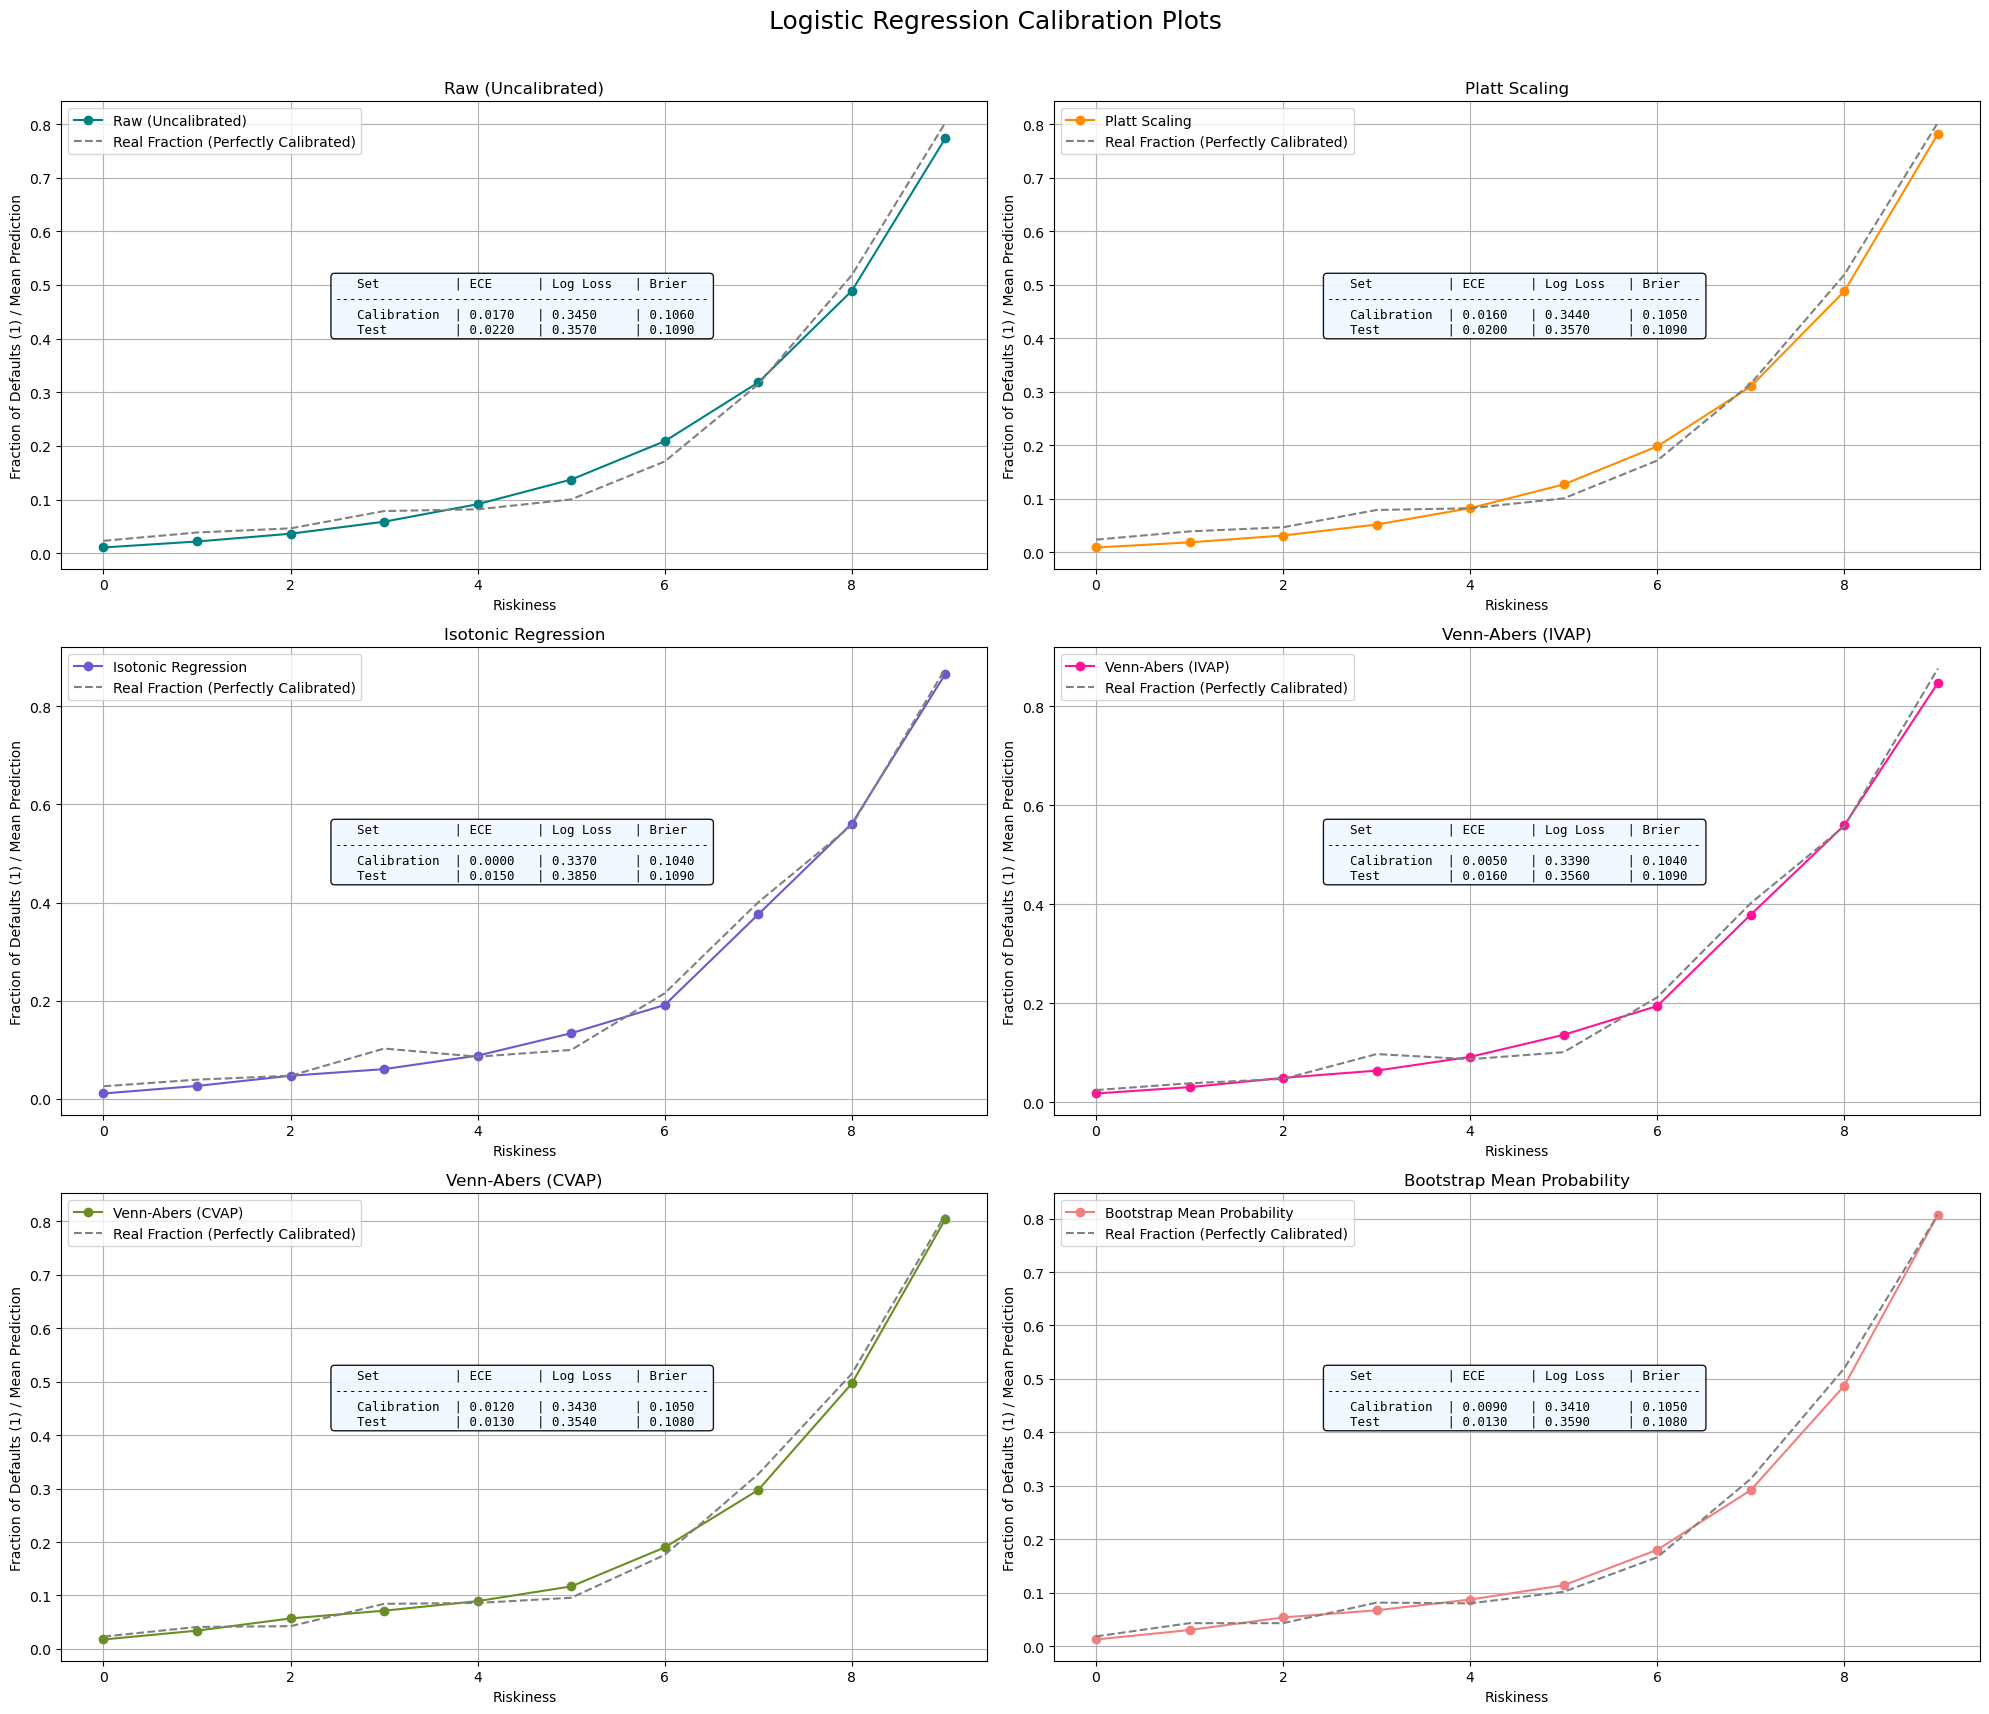

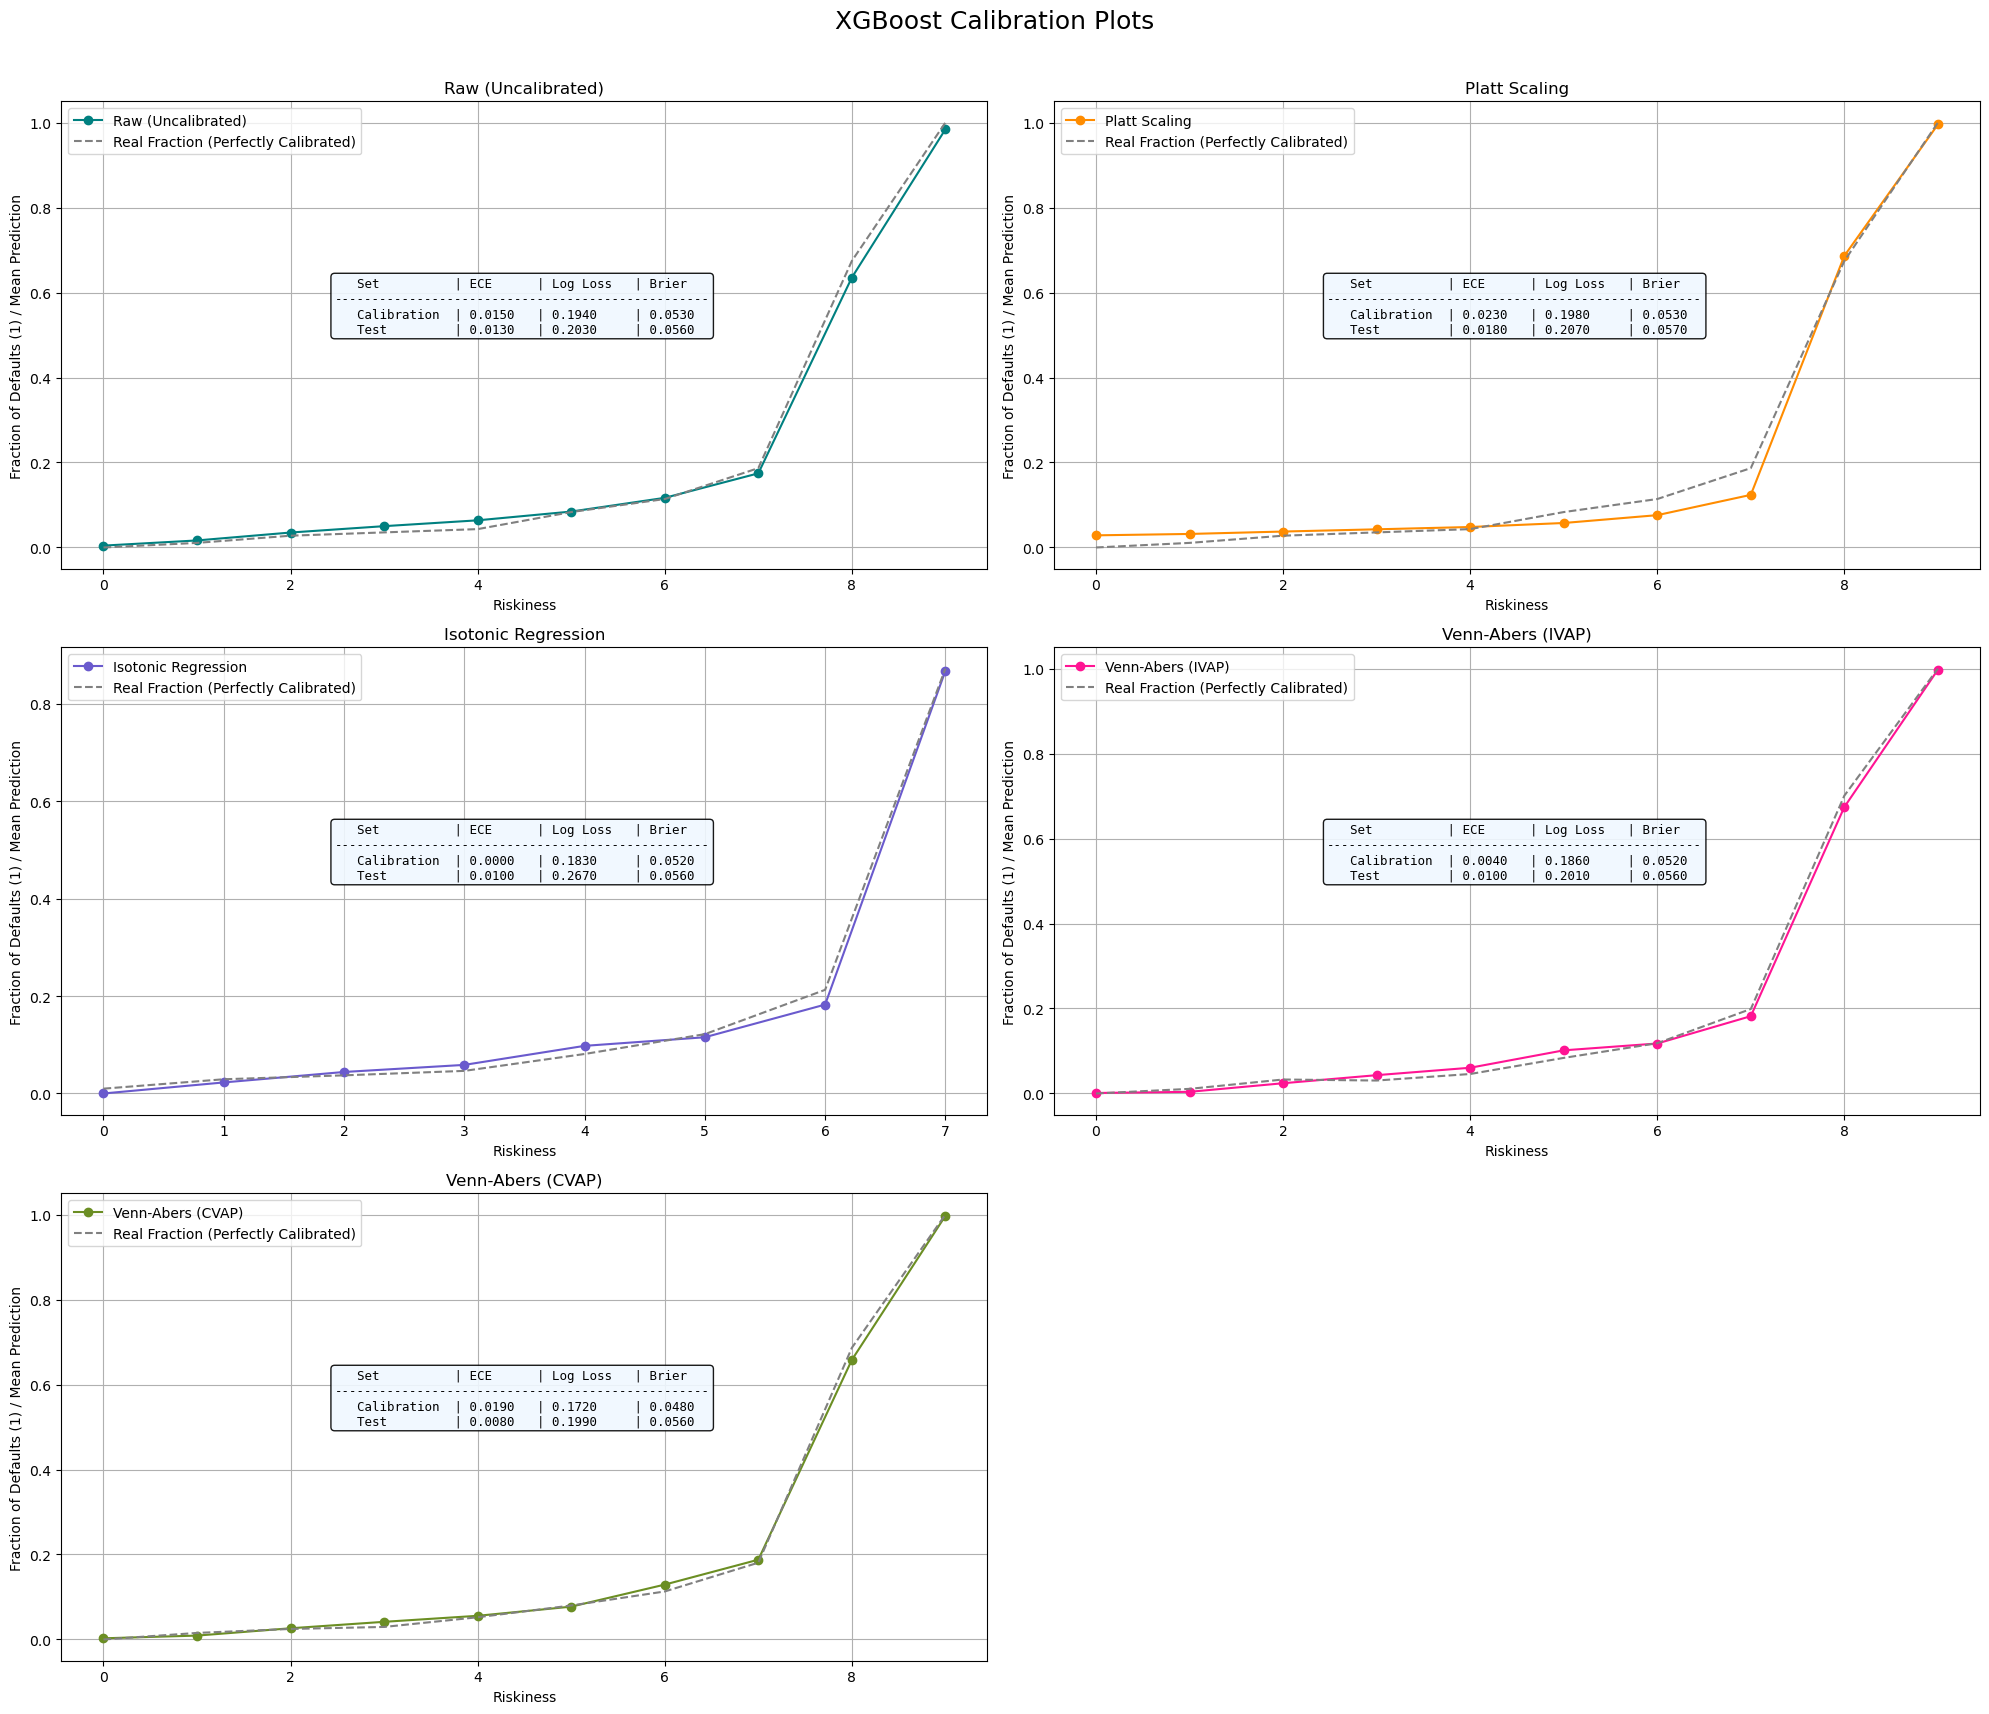

In [41]:
# Assuming 'test', 'calibration_perf_test', and 'calibration_perf_valid' DataFrames are available

# --- 1. Prepare both metrics DataFrames by setting the index ---
# calibration_perf_test.set_index('Method', inplace=True)
# calibration_perf_valid.set_index('Method', inplace=True)

# --- Define model suffixes and their properties for plotting ---
model_map = {
    'raw_prob': 'Raw (Uncalibrated)',
    'platt_prob': 'Platt Scaling',
    'iso_prob': 'Isotonic Regression',
    'venn_ivap': 'Venn-Abers (IVAP)',
    'venn_cvap': 'Venn-Abers (CVAP)',
    'boot_mean_prob': 'Bootstrap Mean Probability'
}
colors = {
    'raw_prob': 'teal',
    'platt_prob': 'darkorange',
    'iso_prob': 'slateblue',
    'venn_ivap': 'deeppink',
    'venn_cvap': 'olivedrab',
    'boot_mean_prob': 'lightcoral'
}

# --- Outer loop to create a separate figure for each base model ---
for node in ['lr', 'xgb']:
    
    fig, axs = plt.subplots(3, 2, figsize=(20, 18))
    axs = axs.flatten()
    fig.suptitle(f'{"Logistic Regression" if node=="lr" else "XGBoost"} Calibration Plots', fontsize=18)

    # --- Inner loop to create a plot for each model type ---
    for i, model_suffix in enumerate(model_map.keys()):
        ax = axs[i]
        col_name = f'{node}_{model_suffix}' if (model_suffix != 'boot_mean_prob') or (node != 'lr') else 'boot_mean_prob'
        model_name = model_map[model_suffix]

        if col_name in test.columns:
            # Plotting logic remains the same
            fraction_of_positives, mean_predicted_value = calibration_curve(
                test['loan_status'], test[col_name], n_bins=10, strategy='quantile'
            )
            
            ax.plot(range(len(mean_predicted_value)), mean_predicted_value, marker='o', label=model_name, color=colors[model_suffix])
            ax.plot(range(len(fraction_of_positives)), fraction_of_positives, '--', label='Real Fraction (Perfectly Calibrated)', color='grey')
            ax.set_title(model_name)
            ax.set_xlabel('Riskiness')
            ax.set_ylabel('Fraction of Defaults (1) / Mean Prediction')
            ax.legend(loc='upper left')
            ax.grid(True)

            # --- MODIFIED SECTION: Add metrics table for both sets ---
            metric_key = f'{node}_{model_suffix}' if (model_suffix != 'boot_mean_prob') or (node != 'lr') else 'boot_mean_prob'
            
            # Initialize metrics_text with a header
            metrics_text = f'{"Set":<12} | {"ECE":<8} | {"Log Loss":<10} | {"Brier":<8}\n'
            metrics_text += "-" * 50 + "\n"
            
            # Get and format VALIDATION metrics
            if metric_key in calibration_perf_valid.index:
                valid_metrics = calibration_perf_valid.loc[metric_key]
                metrics_text += (f'{"Calibration":<12} | {valid_metrics["ECE"]:<8.4f} | '
                                 f'{valid_metrics["Log Loss"]:<10.4f} | {valid_metrics["Brier Score"]:<8.4f}\n')

            # Get and format TEST metrics
            if metric_key in calibration_perf_test.index:
                test_metrics = calibration_perf_test.loc[metric_key]
                metrics_text += (f'{"Test":<12} | {test_metrics["ECE"]:<8.4f} | '
                                 f'{test_metrics["Log Loss"]:<10.4f} | {test_metrics["Brier Score"]:<8.4f}')
            
            bbox_props = dict(boxstyle='round,pad=0.3', fc='aliceblue', alpha=0.9)
            
            # Add the text box to the subplot
            ax.text(0.7, 0.5, metrics_text, transform=ax.transAxes, fontsize=9,
                    verticalalignment='bottom', horizontalalignment='right', bbox=bbox_props, fontname='monospace')
            # --- End of Modified Section ---

        else:
        #     ax.text(0.5, 0.5, f'Column "{col_name}"\nnot found', 
        #             ha='center', va='center', fontsize=12, color='red')
            ax.axis('off')

    # Hide any unused subplots
    if len(model_map) < len(axs):
        for j in range(len(model_map), len(axs)):
            fig.delaxes(axs[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

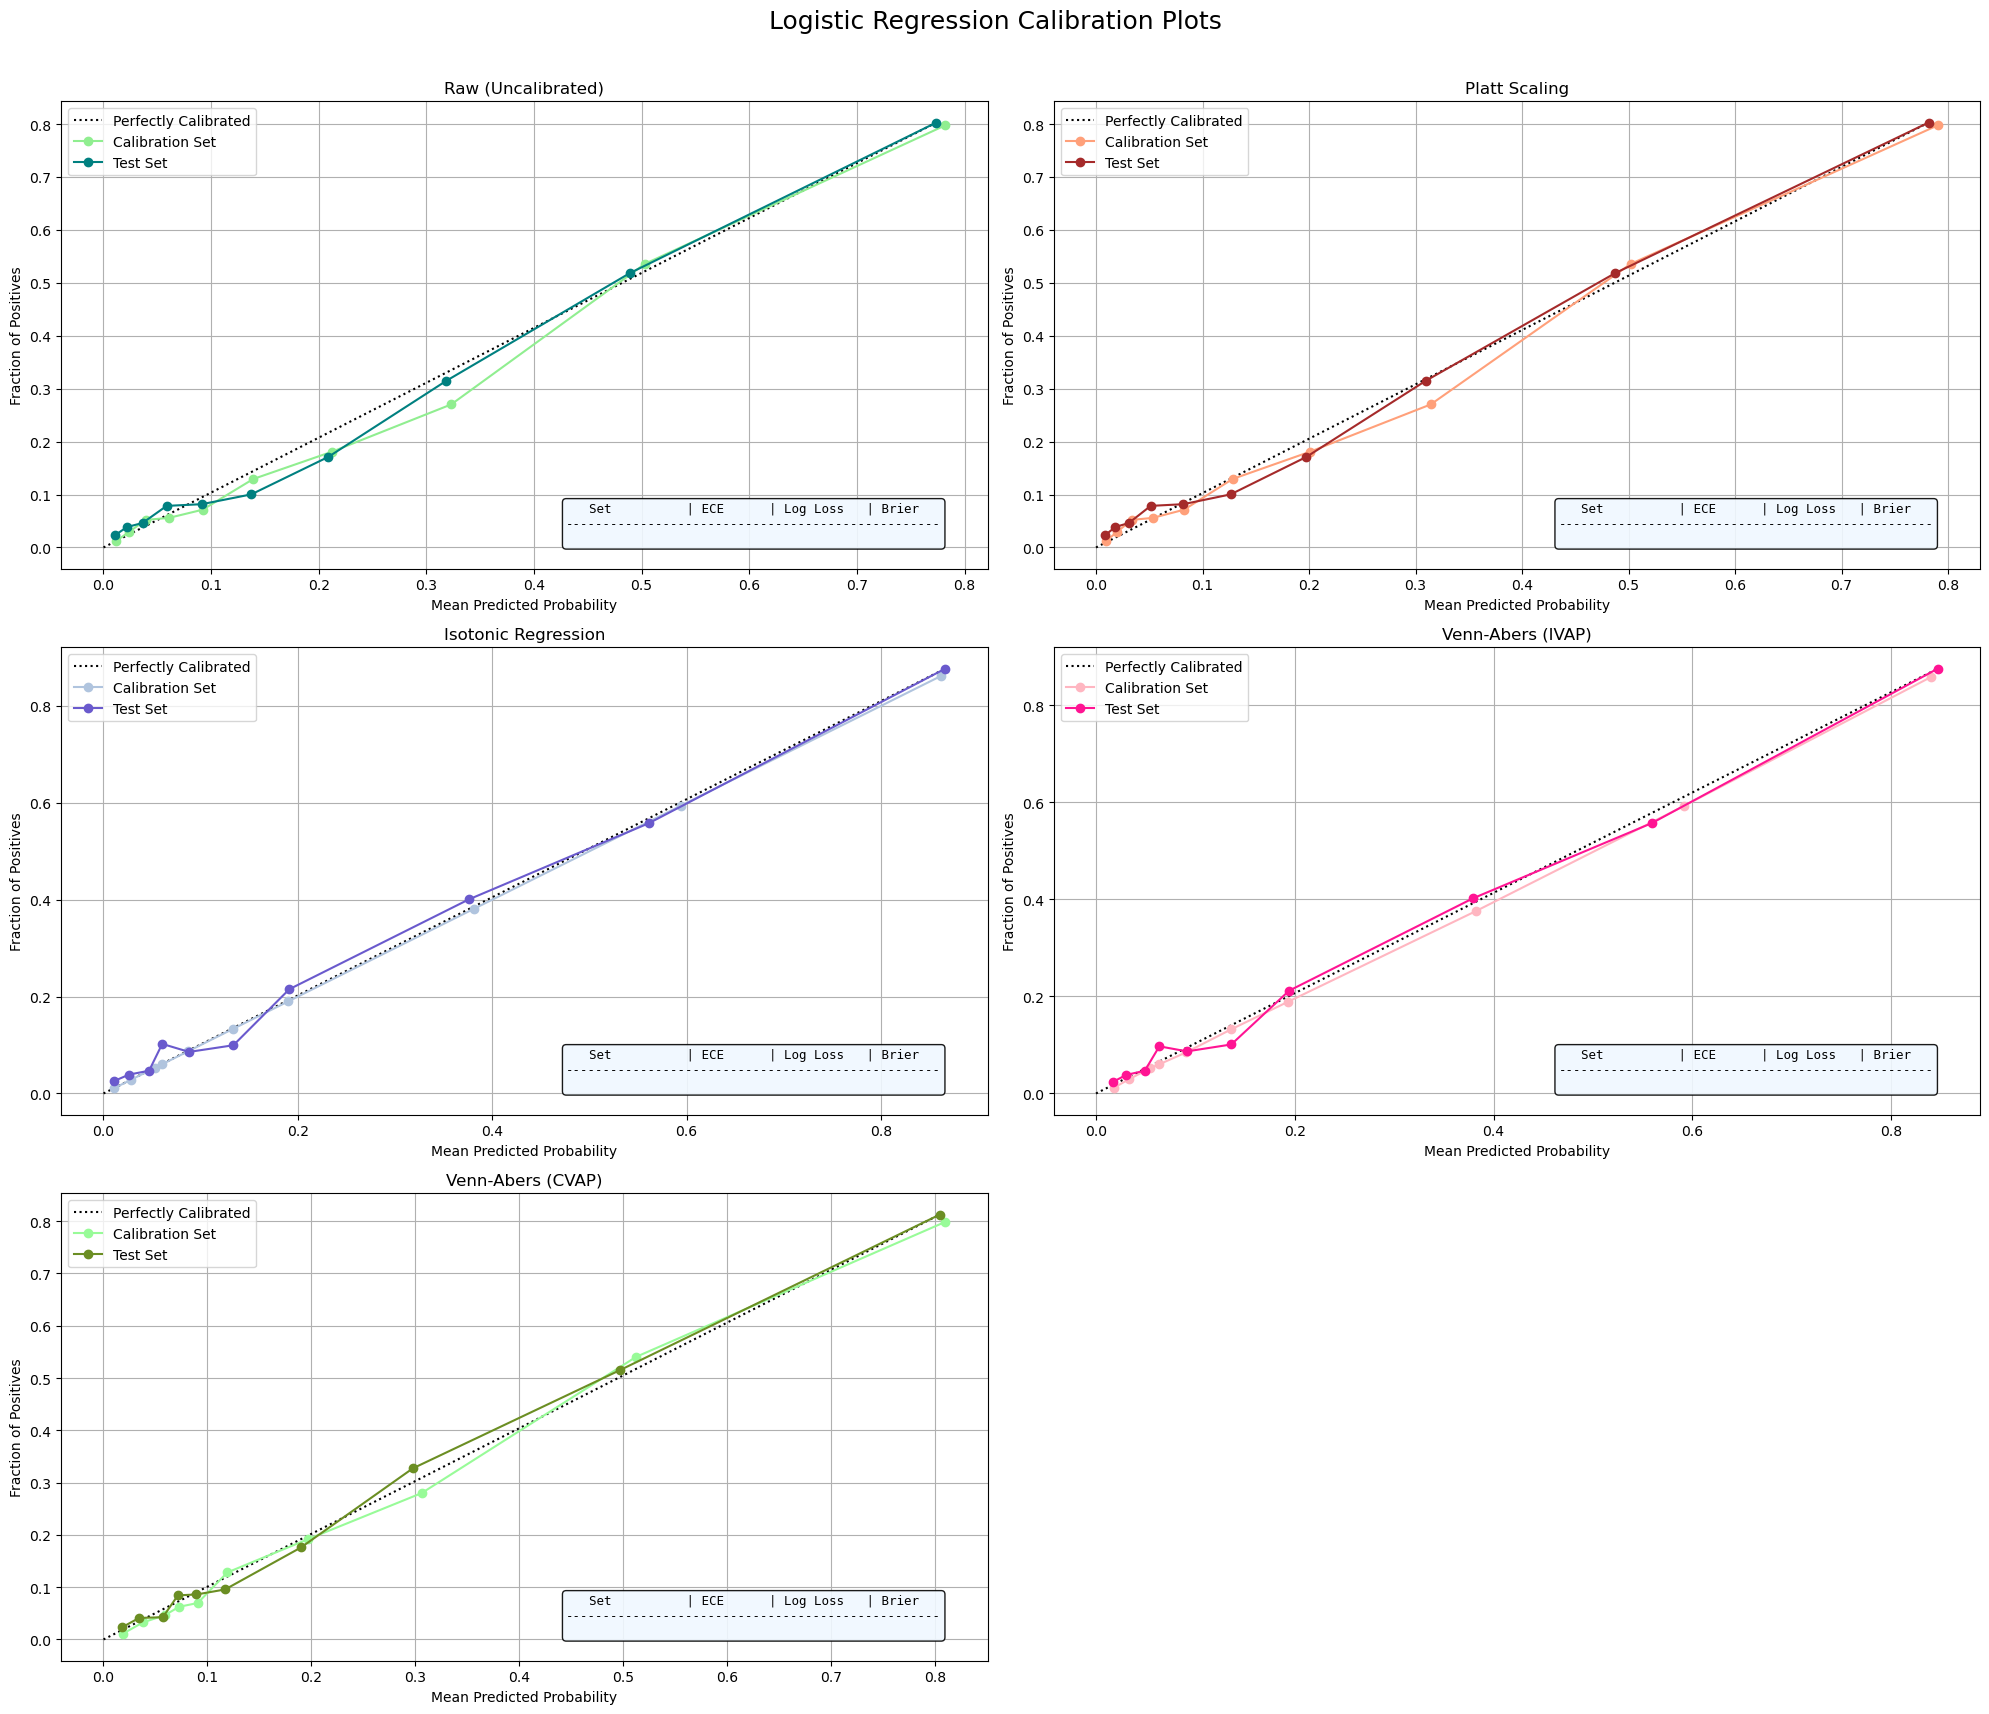

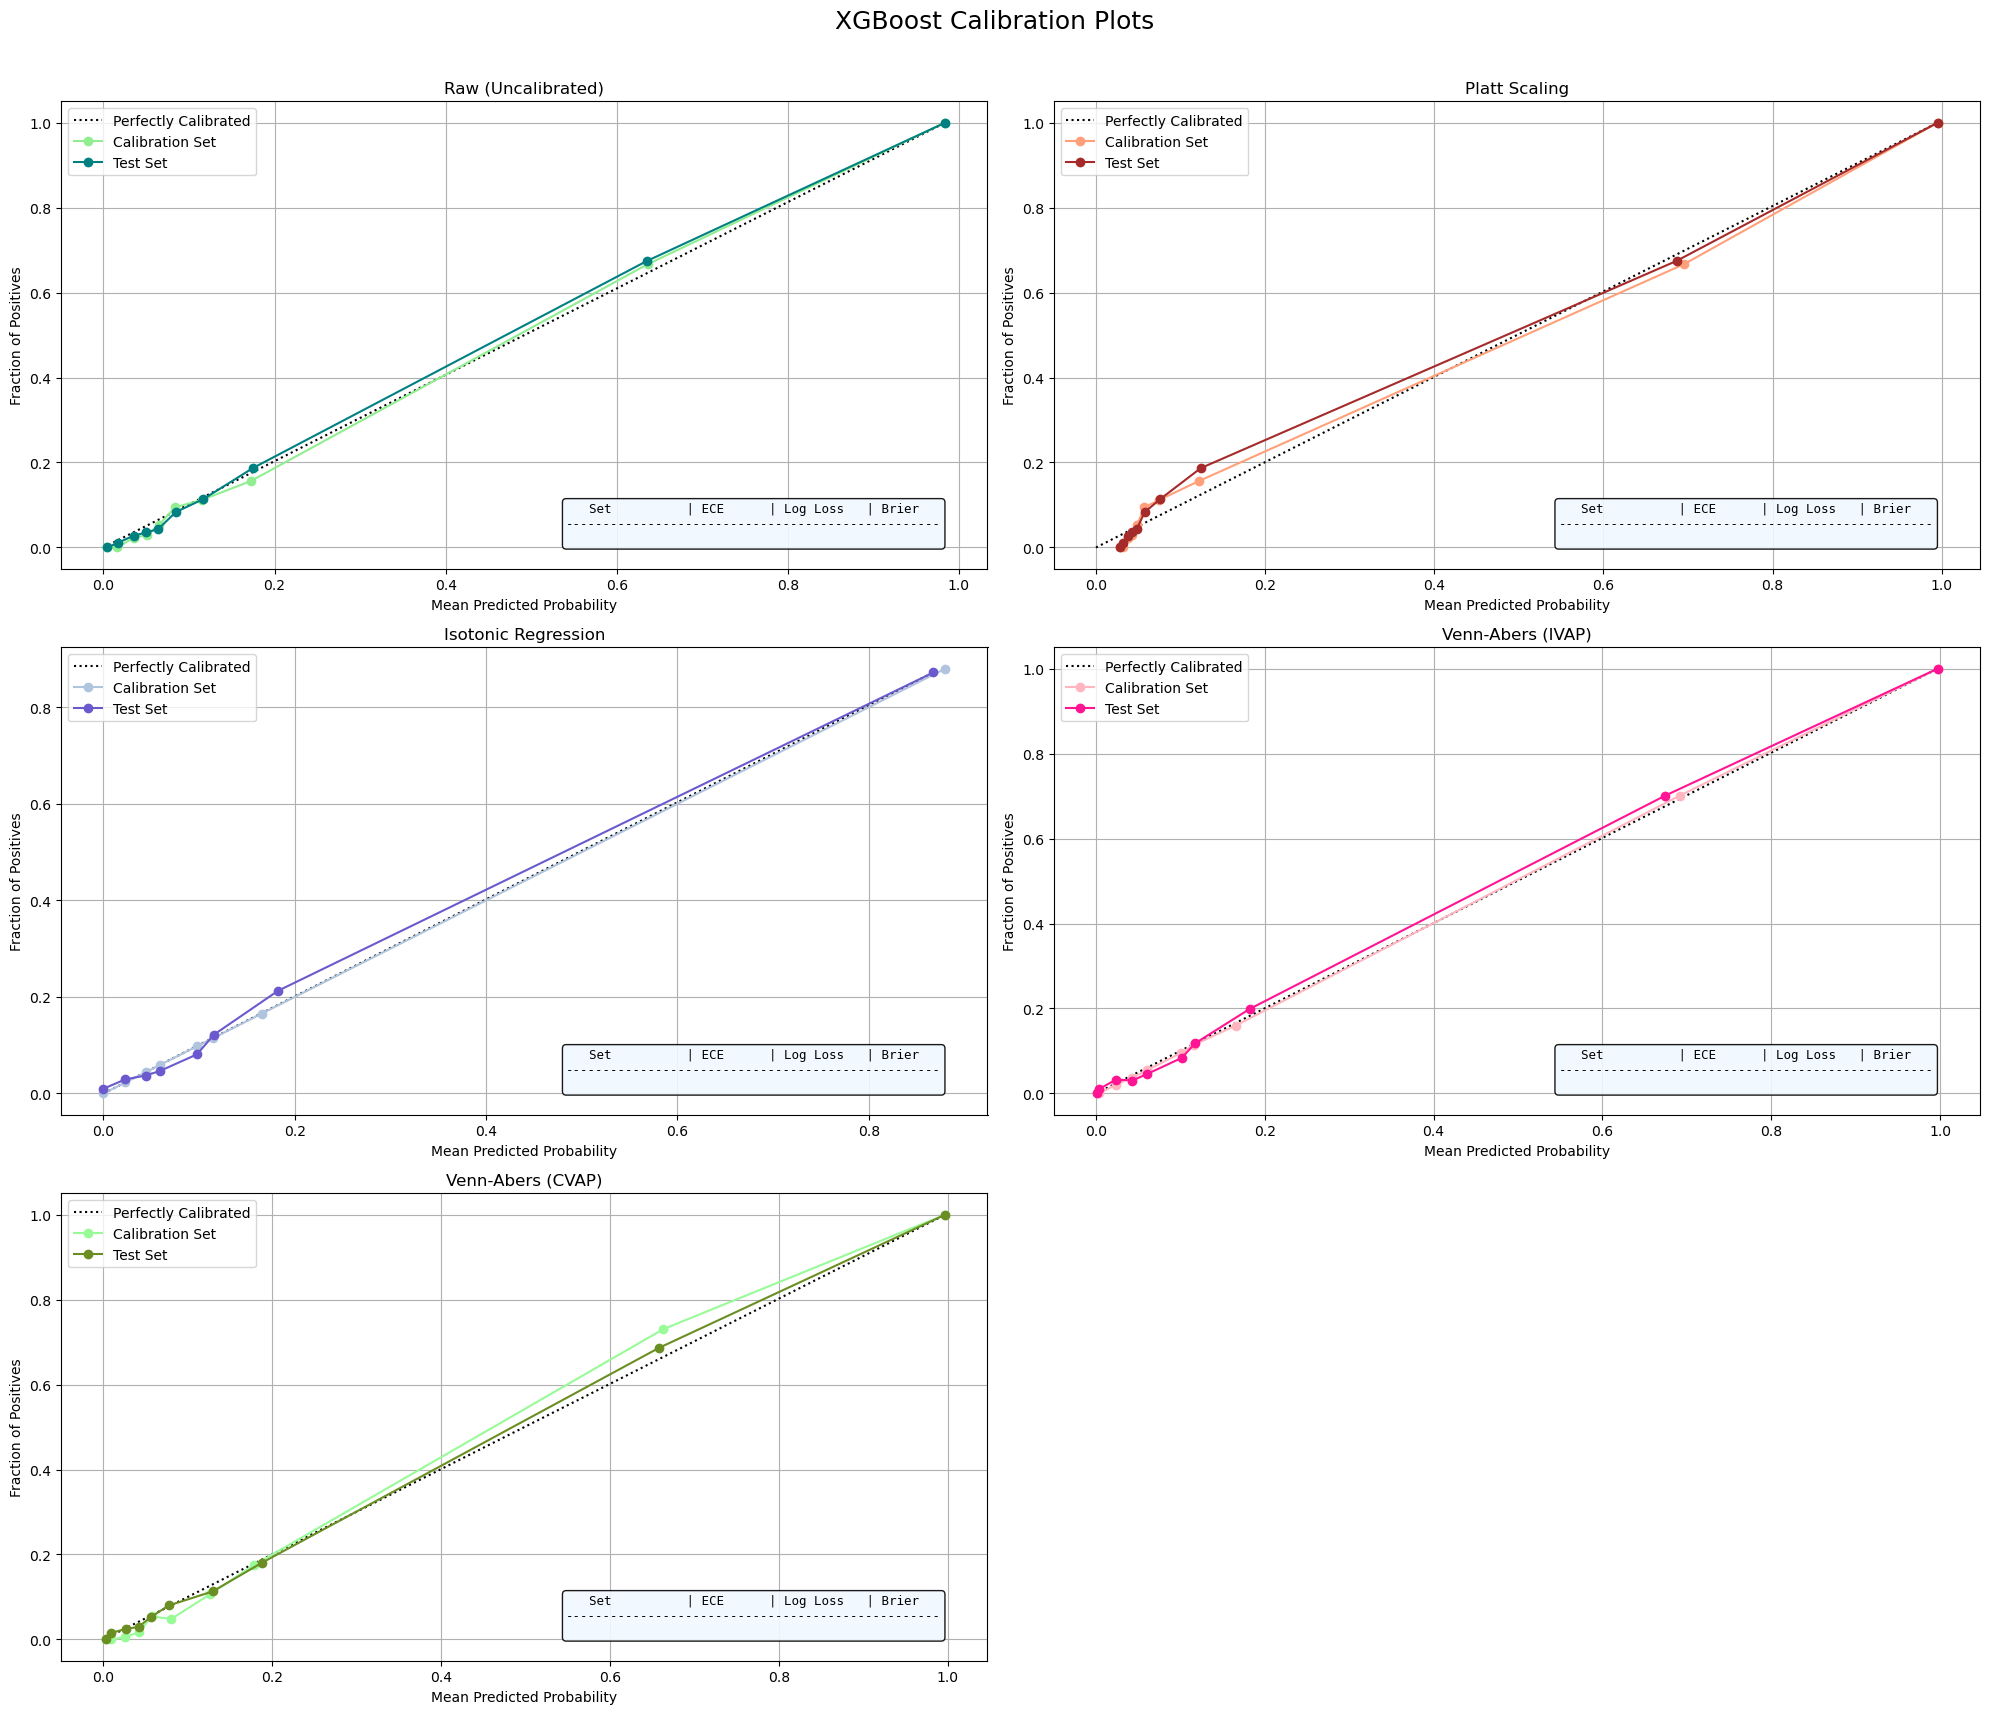

In [38]:
# Assuming 'test', 'calibration_perf_test', and 'calibration_perf_valid' DataFrames are available

# --- 1. Prepare both metrics DataFrames by setting the index ---
# calibration_perf_test.set_index('Method', inplace=True)
# calibration_perf_valid.set_index('Method', inplace=True)

# --- Define model suffixes and their properties for plotting ---
model_map = {
    'raw_prob': 'Raw (Uncalibrated)',
    'platt_prob': 'Platt Scaling',
    'iso_prob': 'Isotonic Regression',
    'venn_ivap': 'Venn-Abers (IVAP)',
    'venn_cvap': 'Venn-Abers (CVAP)'
}
colors = {
    'raw_prob': ['teal', 'lightgreen'],
    'platt_prob': ['brown', 'lightsalmon'],
    'iso_prob': ['slateblue', 'lightsteelblue'],
    'venn_ivap': ['deeppink', 'lightpink'],
    'venn_cvap': ['olivedrab', 'palegreen']
}

# --- Outer loop to create a separate figure for each base model ---
for node in ['lr', 'xgb']:
    
    fig, axs = plt.subplots(3, 2, figsize=(20, 18))
    axs = axs.flatten()
    fig.suptitle(f'{"Logistic Regression" if node=="lr" else "XGBoost"} Calibration Plots', fontsize=18)

    # --- Inner loop to create a plot for each model type ---
    for i, model_suffix in enumerate(model_map.keys()):
        ax = axs[i]
        col_name = f'{node}_{model_suffix}'
        model_name = model_map[model_suffix]

        if col_name in test.columns:
            # Plotting logic remains the same
            fraction_of_positives_val, mean_predicted_value_val = calibration_curve(
                valid['loan_status'], valid[col_name], n_bins=10, strategy='quantile'
            )
            
            fraction_of_positives, mean_predicted_value = calibration_curve(
                test['loan_status'], test[col_name], n_bins=10, strategy='quantile'
            )
            
            ax.plot([0, max(mean_predicted_value)], [0, max(fraction_of_positives)], 'k:', label='Perfectly Calibrated')
            ax.plot(mean_predicted_value_val, fraction_of_positives_val, marker='o', label='Calibration Set', color=colors[model_suffix][1])
            ax.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Test Set', color=colors[model_suffix][0])

            ax.set_title(model_name)
            ax.set_xlabel('Mean Predicted Probability')
            ax.set_ylabel('Fraction of Positives')
            ax.legend()
            ax.grid(True)

            # --- MODIFIED SECTION: Add metrics table for both sets ---
            metric_key = f'{node}_{model_suffix}'
            
            # Initialize metrics_text with a header
            metrics_text = f'{"Set":<12} | {"ECE":<8} | {"Log Loss":<10} | {"Brier":<8}\n'
            metrics_text += "-" * 50 + "\n"
            
            # Get and format VALIDATION metrics
            if metric_key in calibration_perf_valid.index:
                valid_metrics = calibration_perf_valid.loc[metric_key]
                metrics_text += (f'{"Validation":<12} | {valid_metrics["ECE"]:<8.4f} | '
                                 f'{valid_metrics["Log Loss"]:<10.4f} | {valid_metrics["Brier Score"]:<8.4f}\n')

            # Get and format TEST metrics
            if metric_key in calibration_perf_test.index:
                test_metrics = calibration_perf_test.loc[metric_key]
                metrics_text += (f'{"Test":<12} | {test_metrics["ECE"]:<8.4f} | '
                                 f'{test_metrics["Log Loss"]:<10.4f} | {test_metrics["Brier Score"]:<8.4f}')
            
            bbox_props = dict(boxstyle='round,pad=0.3', fc='aliceblue', alpha=0.9)
            
            # Add the text box to the subplot
            ax.text(0.95, 0.05, metrics_text, transform=ax.transAxes, fontsize=9,
                    verticalalignment='bottom', horizontalalignment='right', bbox=bbox_props, fontname='monospace')
            # --- End of Modified Section ---

        else:
            ax.text(0.5, 0.5, f'Column "{col_name}"\nnot found', 
                    ha='center', va='center', fontsize=12, color='red')
            ax.axis('off')

    # Hide any unused subplots
    if len(model_map) < len(axs):
        for j in range(len(model_map), len(axs)):
            fig.delaxes(axs[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

### *Calibration Charachteristics*

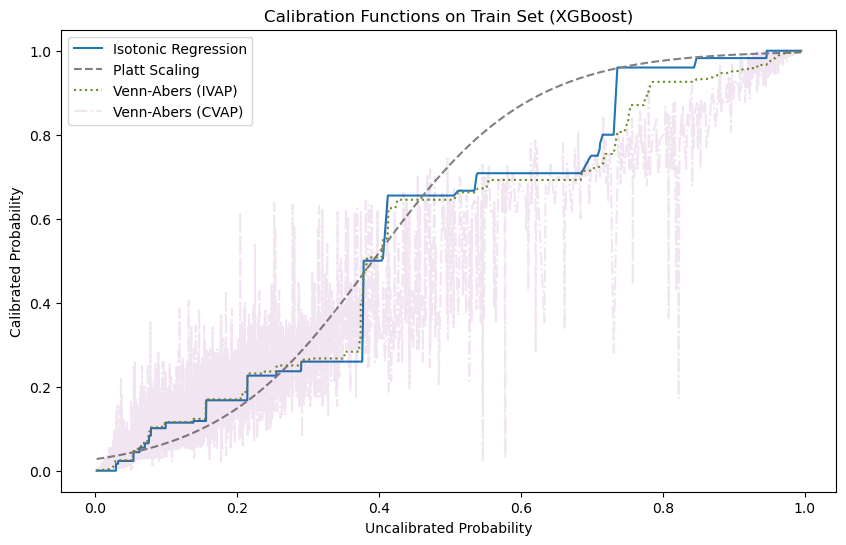

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train.sort_values('xgb_raw_prob')['xgb_raw_prob'], train.sort_values('xgb_raw_prob')['xgb_iso_prob'], label='Isotonic Regression')
plt.plot(train.sort_values('xgb_raw_prob')['xgb_raw_prob'], train.sort_values('xgb_raw_prob')['xgb_platt_prob'], linestyle='--', color='gray', label='Platt Scaling')
plt.plot(train.sort_values('xgb_raw_prob')['xgb_raw_prob'], train.sort_values('xgb_raw_prob')['xgb_venn_ivap'], linestyle=':', color='olivedrab', label='Venn-Abers (IVAP)')
plt.plot(train.sort_values('xgb_raw_prob')['xgb_raw_prob'], train.sort_values('xgb_raw_prob')['xgb_venn_cvap'], linestyle='-.', color='purple', label='Venn-Abers (CVAP)', alpha=0.1)
plt.xlabel('Uncalibrated Probability')
plt.ylabel('Calibrated Probability')
plt.title('Calibration Functions on Train Set (XGBoost)')
plt.legend()    
plt.show()

# Interval Predictions

In [56]:
valid.head()

,ID,xgb_raw_prob,xgb_platt_prob,xgb_iso_prob,xgb_venn_ivap,xgb_p0_ivap,xgb_p1_ivap,xgb_venn_cvap,xgb_mean_p0_cvap,xgb_mean_p1_cvap,...,lr_p1_ivap,lr_venn_cvap,lr_mean_p0_cvap,lr_mean_p1_cvap,lr_min_p0_cvap,lr_max_p1_cvap,boot_lower_bound,boot_upper_bound,boot_mean_prob,xgb_ivap_width
0,8881,0.412257,0.547426,0.655172,0.571429,0.500000,0.666667,0.599018,0.556477,0.652263,...,0.210407,0.264590,0.257335,0.269181,0.211823,0.307692,0.232438,0.391443,0.292649,0.166667
1,22262,0.097211,0.064115,0.101266,0.107867,0.101010,0.108696,0.106692,0.100109,0.108131,...,0.574324,0.515650,0.508582,0.522907,0.465116,0.563830,0.429534,0.578584,0.519704,0.007686
2,10162,0.140037,0.091911,0.118421,0.123377,0.117647,0.124183,0.154612,0.151777,0.155471,...,0.588235,0.568542,0.564401,0.573573,0.520231,0.600000,0.527208,0.643259,0.581138,0.006536
3,32333,0.058661,0.045996,0.044118,0.049366,0.043988,0.049645,0.038480,0.034587,0.040604,...,0.068966,0.080727,0.078374,0.081135,0.068027,0.085399,0.060168,0.102160,0.078981,0.005657
4,14369,0.003259,0.028277,0.000000,0.000973,0.000000,0.000974,0.001840,0.000000,0.001888,...,0.012658,0.013905,0.001695,0.014654,0.000000,0.020408,0.000000,0.012000,0.002338,0.000974


In [60]:
# XGBoost width
valid['xgb_ivap_width'] = valid['xgb_p1_ivap'] - valid['xgb_p0_ivap']
valid['xgb_cvap_width_mean'] = valid['xgb_mean_p1_cvap'] - valid['xgb_mean_p0_cvap']
valid['xgb_cvap_width_minmax'] = valid['xgb_max_p1_cvap'] - valid['xgb_min_p0_cvap']

test['xgb_ivap_width'] = test['xgb_p1_ivap'] - test['xgb_p0_ivap']
test['xgb_cvap_width_mean'] = test['xgb_mean_p1_cvap'] - test['xgb_mean_p0_cvap']
test['xgb_cvap_width_minmax'] = test['xgb_max_p1_cvap'] - test['xgb_min_p0_cvap']

# Logistic Regression width
valid['lr_ivap_width'] = valid['lr_p1_ivap'] - valid['lr_p0_ivap']
valid['lr_cvap_width_mean'] = valid['lr_mean_p1_cvap'] - valid['lr_mean_p0_cvap']
valid['lr_cvap_width_minmax'] = valid['lr_max_p1_cvap'] - valid['lr_min_p0_cvap']   

test['lr_ivap_width'] = test['lr_p1_ivap'] - test['lr_p0_ivap']
test['lr_cvap_width_mean'] = test['lr_mean_p1_cvap'] - test['lr_mean_p0_cvap']
test['lr_cvap_width_minmax'] = test['lr_max_p1_cvap'] - test['lr_min_p0_cvap']

# Logistic regression bootstrap width
valid['lr_boot_width'] = valid['boot_upper_bound'] - valid['boot_lower_bound']
test['lr_boot_width'] = test['boot_upper_bound'] - test['boot_lower_bound']

## Analsysis

In [58]:
# Select only the width columns from your test dataframe
width_cols = [col for col in test.columns if '_width' in col]

# Calculate the mean for each width column
width_summary = test[width_cols].mean().reset_index()
width_summary.columns = ['Method', 'Average Interval Width']

# Sort for easier comparison
width_summary = width_summary.sort_values(by='Average Interval Width').reset_index(drop=True)

print("--- Average Interval Width on Test Set ---")
display(width_summary)

--- Average Interval Width on Test Set ---


,Method,Average Interval Width
0,xgb_ivap_width,0.006686
1,xgb_cvap_width_mean,0.006909
2,lr_ivap_width,0.008043
3,lr_cvap_width_mean,0.008117
4,xgb_cvap_width_minmax,0.033290
5,lr_cvap_width_minmax,0.051418


C:\Users\User\AppData\Local\Temp\ipykernel_7716\424316986.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sharpness_data = test.groupby('prob_bin')[[width_col]].mean().reset_index()
C:\Users\User\AppData\Local\Temp\ipykernel_7716\424316986.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sharpness_data = test.groupby('prob_bin')[[width_col]].mean().reset_index()
C:\Users\User\AppData\Local\Temp\ipykernel_7716\424316986.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=

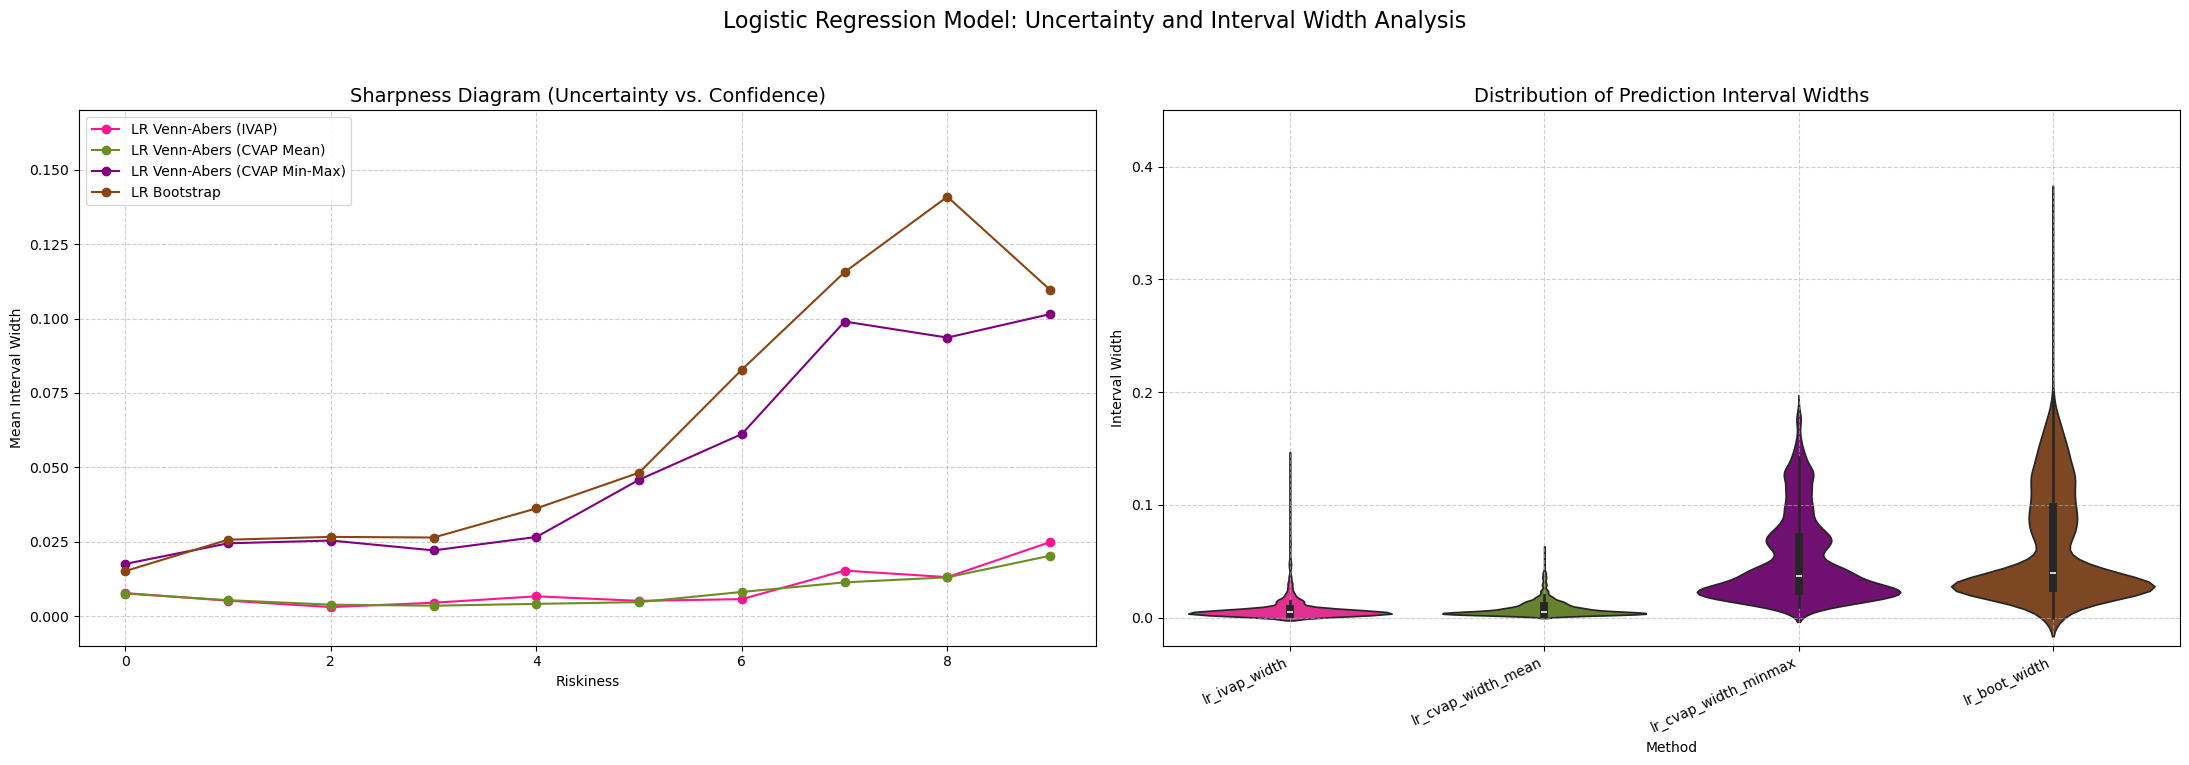

C:\Users\User\AppData\Local\Temp\ipykernel_7716\424316986.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sharpness_data = test.groupby('prob_bin')[[width_col]].mean().reset_index()
C:\Users\User\AppData\Local\Temp\ipykernel_7716\424316986.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sharpness_data = test.groupby('prob_bin')[[width_col]].mean().reset_index()
C:\Users\User\AppData\Local\Temp\ipykernel_7716\424316986.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=

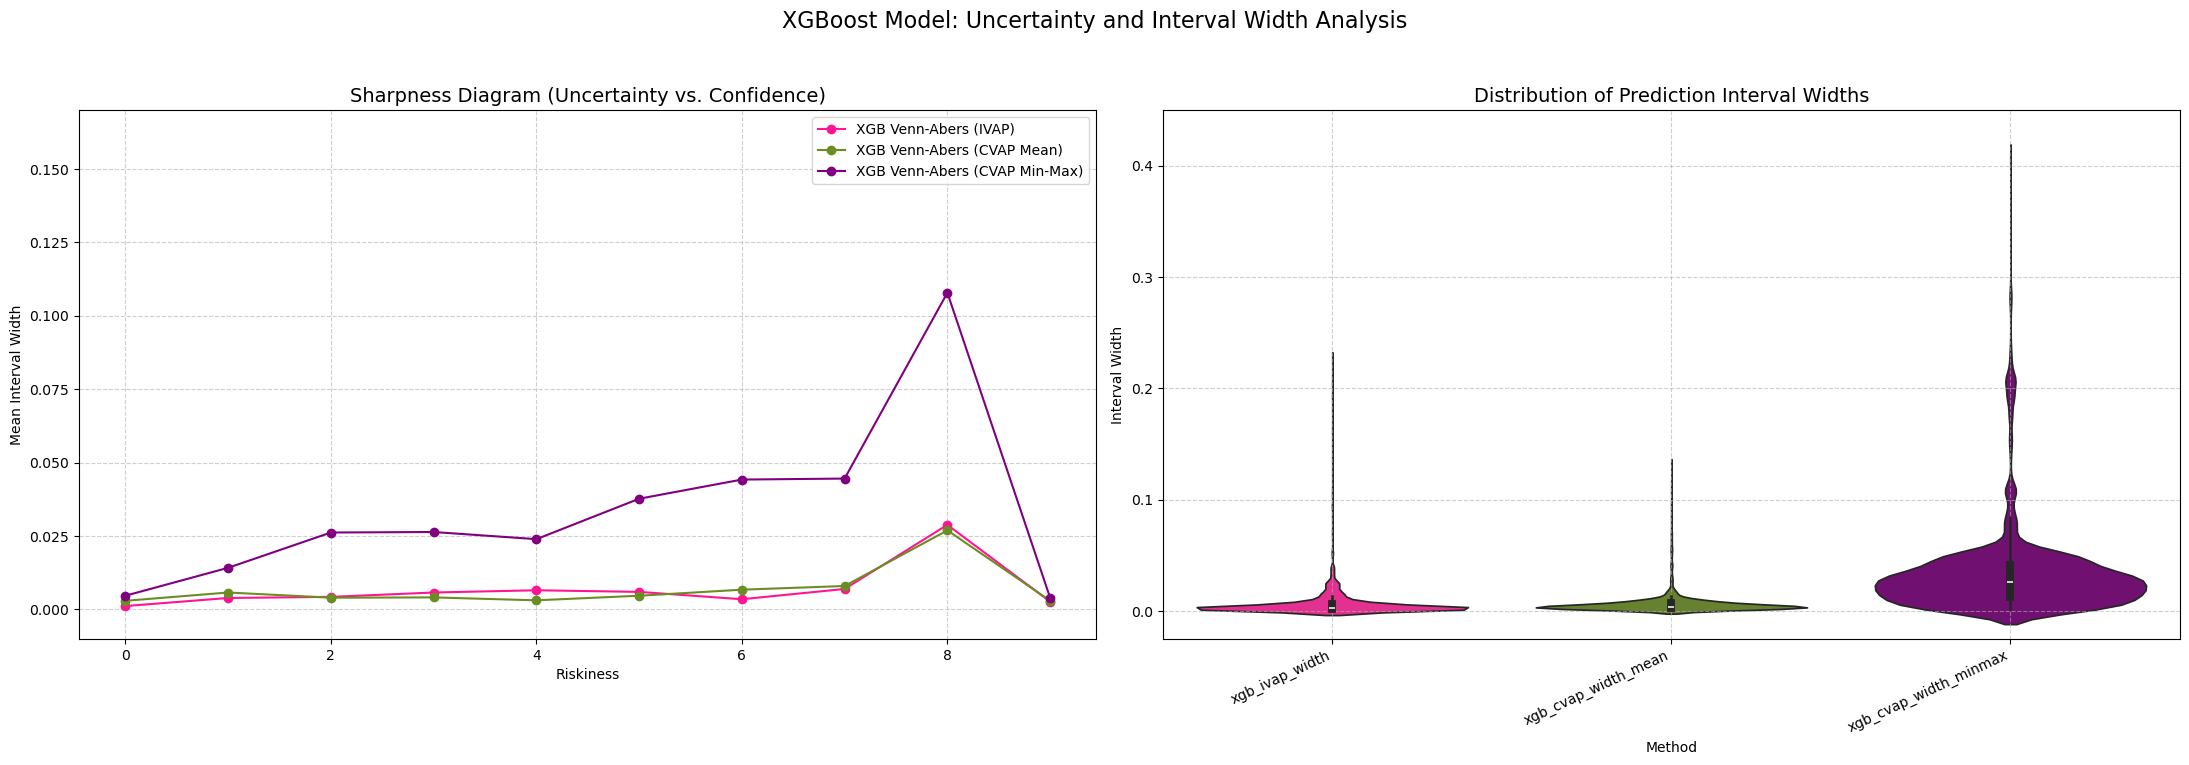

In [145]:
# Assuming 'test' and 'valid' DataFrames are loaded

# --- Define the methods to plot with their EXACT column names and consistent colors ---
# This dictionary drives the sharpness plot
method_definitions = {
    'xgb': [
        {
            'label': 'XGB Venn-Abers (IVAP)',
            'prob_col': 'xgb_venn_ivap',
            'width_col': 'xgb_ivap_width',
            'color': 'deeppink'
        },
        {
            'label': 'XGB Venn-Abers (CVAP Mean)',
            'prob_col': 'xgb_venn_cvap',
            'width_col': 'xgb_cvap_width_mean',
            'color': 'olivedrab'
        },
        {
            'label': 'XGB Venn-Abers (CVAP Min-Max)',
            'prob_col': 'xgb_venn_cvap',
            'width_col': 'xgb_cvap_width_minmax',
            'color': 'purple'
        }
    ],
    'lr': [
        {
            'label': 'LR Venn-Abers (IVAP)',
            'prob_col': 'lr_venn_ivap',
            'width_col': 'lr_ivap_width',
            'color': 'deeppink'
        },
        {
            'label': 'LR Venn-Abers (CVAP Mean)',
            'prob_col': 'lr_venn_cvap',
            'width_col': 'lr_cvap_width_mean',
            'color': 'olivedrab'
        },
        {
            'label': 'LR Venn-Abers (CVAP Min-Max)',
            'prob_col': 'lr_venn_cvap',
            'width_col': 'lr_cvap_width_minmax',
            'color': 'purple'
        },
        {
            'label': 'LR Bootstrap',
            'prob_col': 'boot_mean_prob',
            'width_col': 'lr_boot_width',
            'color': 'saddlebrown'
        }
    ]
}

# --- NEW: Create a color palette dictionary for the violin plot ---
# This maps the column names (which become categories) to the desired colors
color_palette = {
    'xgb_ivap_width': 'deeppink',
    'xgb_cvap_width_mean': 'olivedrab',
    'xgb_cvap_width_minmax': 'purple',
    'lr_ivap_width': 'deeppink',
    'lr_cvap_width_mean': 'olivedrab',
    'lr_cvap_width_minmax': 'purple',
    'lr_boot_width': 'saddlebrown'
}


# --- Loop to create a separate figure for each base model ---
for node in ['lr', 'xgb']:
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))
    title = 'Logistic Regression' if node == 'lr' else 'XGBoost'
    fig.suptitle(f'{title} Model: Uncertainty and Interval Width Analysis', fontsize=16)

    # --- Left Plot: Sharpness Diagram ---
    sharpness_methods = method_definitions[node]
    for method in sharpness_methods:
        prob_col, width_col = method['prob_col'], method['width_col']
        test['prob_bin'] = pd.qcut(test[prob_col], q=10, duplicates='drop')
        sharpness_data = test.groupby('prob_bin')[[width_col]].mean().reset_index()
        # sharpness_data['prob_bin'] = sharpness_data['prob_bin'].astype('str')

        # ax1.plot(sharpness_data['prob_bin'], sharpness_data[width_col], marker='o', 
        #          linestyle='-', label=method['label'], color=method['color'])
        ax1.plot(range(len(sharpness_data)), sharpness_data[width_col], marker='o', 
                 linestyle='-', label=method['label'], color=method['color'])

    ax1.set_title('Sharpness Diagram (Uncertainty vs. Confidence)', fontsize=14)
    # plt.setp(ax1.get_xticklabels(), rotation=25, ha="right")
    ax1.set_xlabel('Riskiness')
    ax1.set_ylabel('Mean Interval Width')
    ax1.set_ylim(-0.01, 0.17)
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend()

    # --- Right Plot: Violin Plots of Interval Widths ---
    if node == 'lr':
        width_cols_to_plot = ['lr_ivap_width', 'lr_cvap_width_mean', 'lr_cvap_width_minmax', 'lr_boot_width']
    else: # xgb
        width_cols_to_plot = ['xgb_ivap_width', 'xgb_cvap_width_mean', 'xgb_cvap_width_minmax']
    
    widths_df = test[width_cols_to_plot]
    widths_long = pd.melt(widths_df, var_name='Method', value_name='Interval Width')
    
    # --- MODIFIED LINE: Added the palette argument ---
    sns.violinplot(data=widths_long, x='Method', y='Interval Width', ax=ax2, palette=color_palette)
    
    ax2.set_title('Distribution of Prediction Interval Widths', fontsize=14)
    ax2.set_xlabel('Method')
    ax2.set_ylabel('Interval Width')
    ax2.set_ylim(-0.025, 0.45)
    plt.setp(ax2.get_xticklabels(), rotation=25, ha="right")
    ax2.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [137]:
sharpness_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   prob_bin       10 non-null     category
 1   lr_ivap_width  10 non-null     float64 
dtypes: category(1), float64(1)
memory usage: 678.0 bytes


In [138]:
sharpness_data['prob_bin'].astype('str')

0    (0.00355, 0.0232]
1     (0.0232, 0.0355]
2     (0.0355, 0.0546]
3     (0.0546, 0.0687]
4      (0.0687, 0.111]
5       (0.111, 0.147]
6        (0.147, 0.21]
7         (0.21, 0.39]
8        (0.39, 0.673]
9       (0.673, 0.986]
Name: prob_bin, dtype: object

In [133]:
sharpness_data

<bound method DataFrame.reset_index of           lr_ivap_width
prob_bin               
0              0.007712
1              0.005145
2              0.003004
3              0.004466
4              0.006627
5              0.005094
6              0.005679
7              0.015267
8              0.013076
9              0.024846>

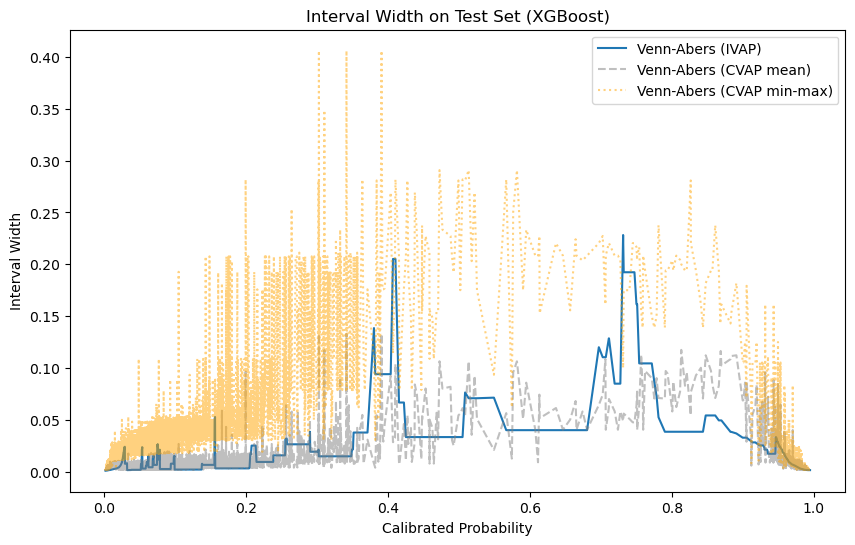

In [149]:
plt.figure(figsize=(10, 6))
plt.plot(test.sort_values('xgb_raw_prob')['xgb_raw_prob'], test.sort_values('xgb_raw_prob')['xgb_ivap_width'], label='Venn-Abers (IVAP)')
plt.plot(test.sort_values('xgb_raw_prob')['xgb_raw_prob'], test.sort_values('xgb_raw_prob')['xgb_cvap_width_mean'], linestyle='--', color='gray', label='Venn-Abers (CVAP mean)', alpha=0.5)
plt.plot(test.sort_values('xgb_raw_prob')['xgb_raw_prob'], test.sort_values('xgb_raw_prob')['xgb_cvap_width_minmax'], linestyle=':', color='orange', label='Venn-Abers (CVAP min-max)', alpha=0.5)
# plt.plot(test.sort_values('xgb_raw_prob')['xgb_raw_prob'], test.sort_values('xgb_raw_prob')['Venn-Abers (CVAP)'], linestyle='-.', color='purple', label='Venn-Abers (CVAP)')
plt.xlabel('Calibrated Probability')
plt.ylabel('Interval Width')
plt.title('Interval Width on Test Set (XGBoost)')
plt.legend()
plt.show()

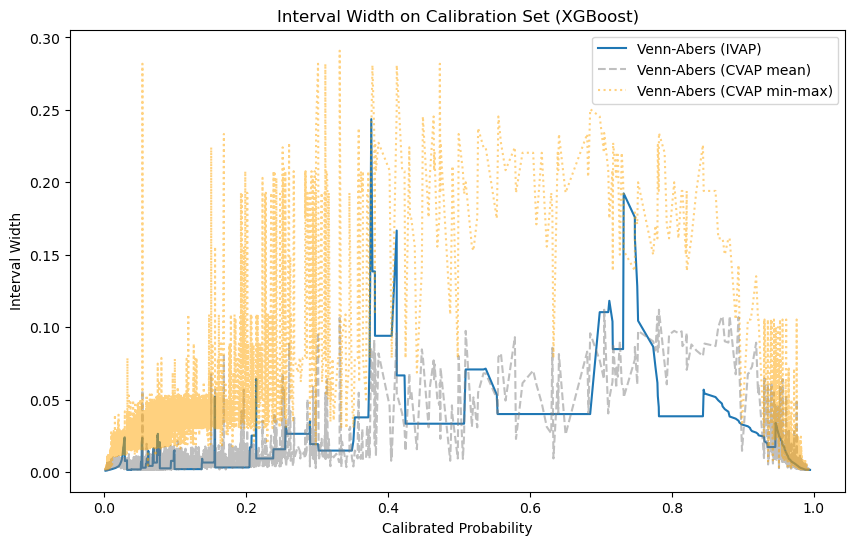

In [121]:
plt.figure(figsize=(10, 6))
plt.plot(valid.sort_values('xgb_raw_prob')['xgb_raw_prob'], valid.sort_values('xgb_raw_prob')['xgb_ivap_width'], label='Venn-Abers (IVAP)')
plt.plot(valid.sort_values('xgb_raw_prob')['xgb_raw_prob'], valid.sort_values('xgb_raw_prob')['xgb_cvap_width_mean'], linestyle='--', color='gray', label='Venn-Abers (CVAP mean)', alpha=0.5)
plt.plot(valid.sort_values('xgb_raw_prob')['xgb_raw_prob'], valid.sort_values('xgb_raw_prob')['xgb_cvap_width_minmax'], linestyle=':', color='orange', label='Venn-Abers (CVAP min-max)', alpha=0.5)
# plt.plot(valid.sort_values('xgb_raw_prob')['xgb_raw_prob'], valid.sort_values('xgb_raw_prob')['Venn-Abers (CVAP)'], linestyle='-.', color='purple', label='Venn-Abers (CVAP)')
plt.xlabel('Calibrated Probability')
plt.ylabel('Interval Width')
plt.title('Interval Width on Calibration Set (XGBoost)')
plt.legend()
plt.show()

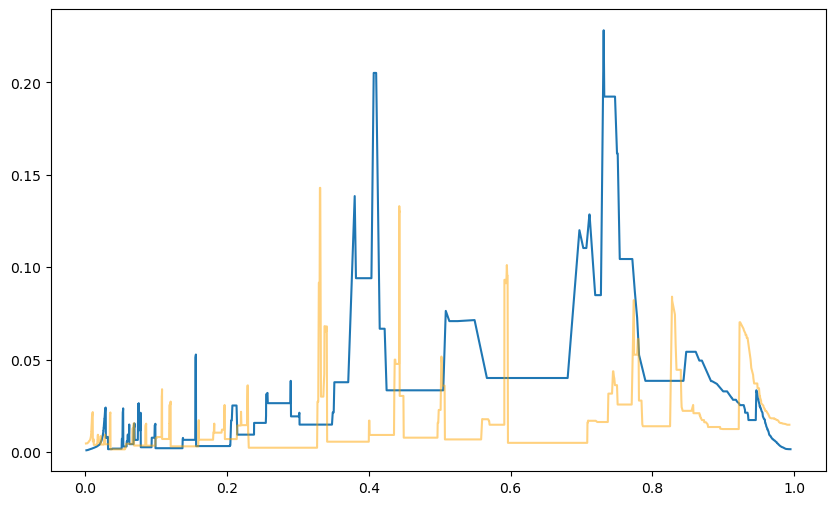

In [154]:
plt.figure(figsize=(10, 6))
plt.plot(test.sort_values('xgb_raw_prob')['xgb_raw_prob'], test.sort_values('xgb_raw_prob')['xgb_ivap_width'], label='Venn-Abers (IVAP) XGBoost')
plt.plot(test.sort_values('lr_raw_prob')['lr_raw_prob'], test.sort_values('lr_raw_prob')['lr_ivap_width'], label='Venn-Abers (IVAP) Logistic Regression', color='orange', alpha=0.5)
plt.show()

In [91]:
test[test['xgb_cvap_width_mean']>=0.05]['loan_status'].value_counts(normalize=True)

loan_status
1    0.775
0    0.225
Name: proportion, dtype: float64

In [122]:
# tmp = test[test['xgb_cvap_width_mean']>=0.05]
tmp = test[test['xgb_ivap_width']>=0.05]

In [ ]:
tmp

,ID,xgb_raw_prob,xgb_platt_prob,xgb_iso_prob,xgb_venn_ivap,xgb_p0_ivap,xgb_p1_ivap,xgb_venn_cvap,xgb_mean_p0_cvap,xgb_mean_p1_cvap,...,boot_upper_bound,boot_mean_prob,xgb_ivap_width,xgb_cvap_width_mean,xgb_cvap_width_minmax,lr_ivap_width,lr_cvap_width_mean,lr_cvap_width_minmax,lr_boot_width,prob_bin
73,1792,0.732303,0.957178,0.960000,0.806452,0.769231,0.961538,0.680473,0.662190,0.718161,...,0.142067,0.107778,0.192308,0.055971,0.175000,0.025417,0.002506,0.041587,0.055979,6
144,18076,0.393354,0.504501,0.500000,0.507812,0.461538,0.555556,0.358842,0.341503,0.370472,...,0.200033,0.139708,0.094017,0.028969,0.175830,0.006601,0.008066,0.068449,0.098615,3
178,23037,0.521999,0.766808,0.666667,0.662762,0.638889,0.709677,0.655534,0.619598,0.712007,...,0.915381,0.851016,0.070789,0.092409,0.269231,0.013889,0.023548,0.137962,0.130394,6
203,5935,0.751209,0.963709,0.960000,0.827815,0.800000,0.961538,0.769223,0.746777,0.823955,...,0.597766,0.509833,0.161538,0.077179,0.204301,0.007708,0.017801,0.069892,0.166905,7
216,19694,0.771892,0.969755,0.960000,0.870647,0.857143,0.961538,0.802156,0.783210,0.873400,...,0.692591,0.612145,0.104396,0.090190,0.150000,0.004902,0.009681,0.109536,0.154672,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5961,30270,0.857381,0.985892,0.982456,0.932243,0.928571,0.982759,0.847759,0.834258,0.918147,...,0.913342,0.832136,0.054187,0.083889,0.194012,0.013889,0.017035,0.137962,0.161633,8
6140,17598,0.390844,0.498784,0.500000,0.507812,0.461538,0.555556,0.520372,0.456106,0.588883,...,0.766889,0.706398,0.094017,0.132777,0.405956,0.004902,0.022781,0.128342,0.115234,5
6165,4547,0.155558,0.104417,0.118421,0.160546,0.117647,0.168750,0.176394,0.173479,0.177484,...,0.078184,0.063344,0.051103,0.004005,0.034586,0.001379,0.001979,0.024972,0.025493,1
6183,18729,0.697224,0.941982,0.746056,0.714286,0.680000,0.800000,0.748087,0.727464,0.791667,...,0.113820,0.090184,0.120000,0.064202,0.220370,0.003390,0.003335,0.017868,0.043337,7


In [124]:
tmp['bin'] = pd.qcut(tmp['xgb_raw_prob'], q=5, duplicates='drop')

C:\Users\User\AppData\Local\Temp\ipykernel_7716\3924296861.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['bin'] = pd.qcut(tmp['xgb_raw_prob'], q=5, duplicates='drop')


In [125]:
tmp.groupby('bin')['loan_status'].agg(['count', 'mean'])

C:\Users\User\AppData\Local\Temp\ipykernel_7716\3105127265.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp.groupby('bin')['loan_status'].agg(['count', 'mean'])


,count,mean
bin,,
"(0.155, 0.382]",14,0.214286
"(0.382, 0.41]",13,0.538462
"(0.41, 0.708]",14,0.714286
"(0.708, 0.751]",13,0.923077
"(0.751, 0.861]",14,0.857143


In [118]:
roc_auc_score(test['loan_status'], test['xgb_venn_cvap'])

0.9384984890338828

In [ ]:
roc_auc_score(test[test['xgb_cvap_width_mean']<0.05]['loan_status'], test[test['xgb_cvap_width_mean']<0.05]['xgb_venn_cvap'])

0.9382182192102224

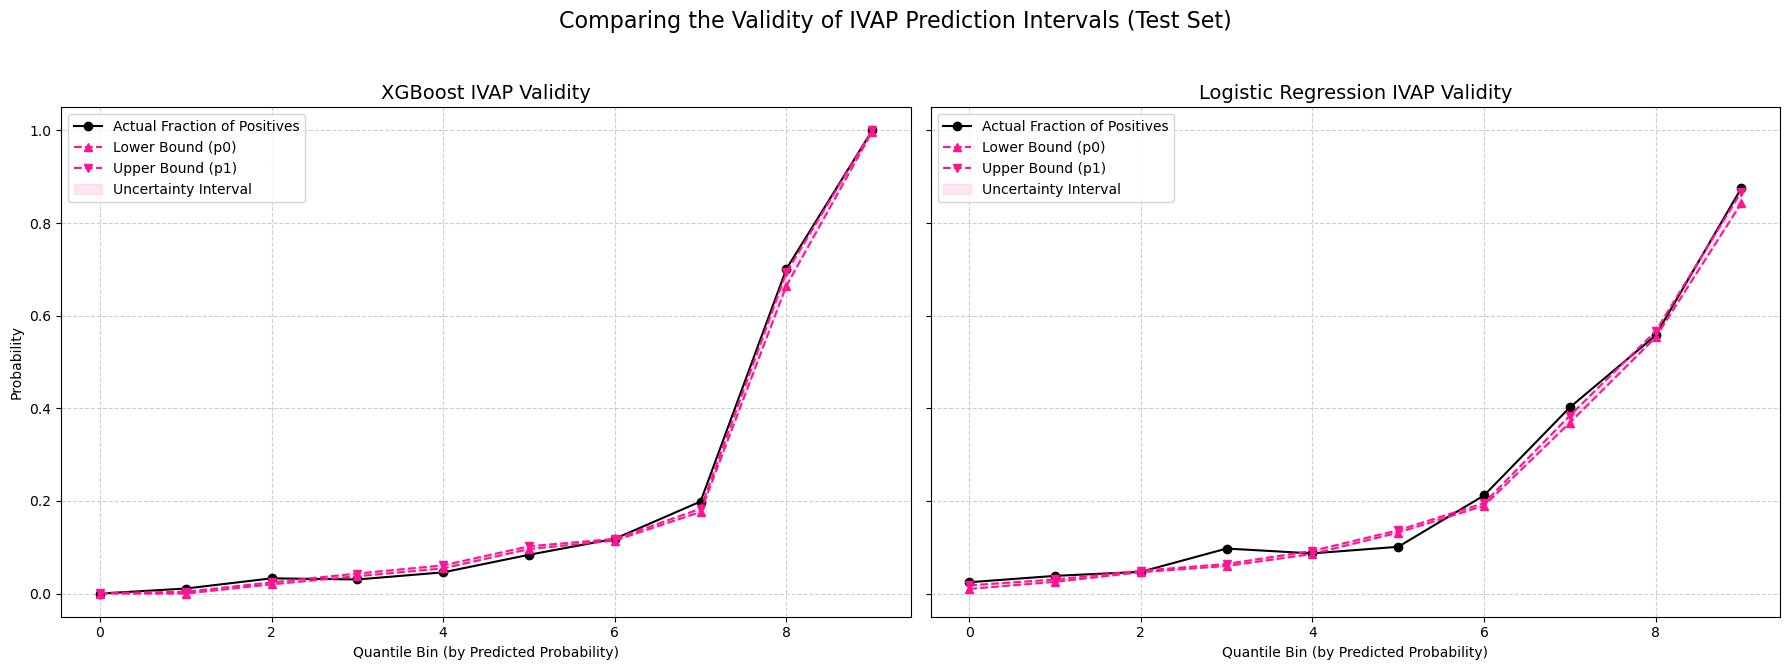

In [164]:
# Assuming 'test' DataFrame is loaded with all probability columns

# --- 1. Setup the figure with two subplots ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
fig.suptitle('Comparing the Validity of IVAP Prediction Intervals (Test Set)', fontsize=16)

# --- 2. Plot for XGBoost IVAP ---
xgb_p0_col = 'xgb_p0_ivap'
xgb_p1_col = 'xgb_p1_ivap'

# For binning, it's best to use the midpoint of the interval
test['xgb_ivap_bin'] = pd.qcut(test['xgb_venn_ivap'], q=10, labels=False, duplicates='drop')

# Group by the bins and calculate the mean of the bounds and the actual outcome
xgb_validity_data = test.groupby('xgb_ivap_bin')[[xgb_p0_col, xgb_p1_col, 'loan_status']].mean()

ax1.plot(xgb_validity_data.index, xgb_validity_data['loan_status'], 
         marker='o', linestyle='-', color='black', label='Actual Fraction of Positives')
ax1.plot(xgb_validity_data.index, xgb_validity_data[xgb_p0_col], 
         marker='^', linestyle='--', color='deeppink', label='Lower Bound (p0)')
ax1.plot(xgb_validity_data.index, xgb_validity_data[xgb_p1_col], 
         marker='v', linestyle='--', color='deeppink', label='Upper Bound (p1)')

# Shade the area between the bounds to represent the uncertainty channel
ax1.fill_between(xgb_validity_data.index, xgb_validity_data[xgb_p0_col], xgb_validity_data[xgb_p1_col], 
                 color='deeppink', alpha=0.1, label='Uncertainty Interval')

ax1.set_title('XGBoost IVAP Validity', fontsize=14)
ax1.set_xlabel('Quantile Bin (by Predicted Probability)')
ax1.set_ylabel('Probability')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend()

# --- 3. Plot for Logistic Regression IVAP ---
lr_p0_col = 'lr_p0_ivap'
lr_p1_col = 'lr_p1_ivap'

# Create bins for the LR model
test['lr_ivap_bin'] = pd.qcut(test['lr_venn_ivap'], q=10, labels=False, duplicates='drop')
lr_validity_data = test.groupby('lr_ivap_bin')[[lr_p0_col, lr_p1_col, 'loan_status']].mean()

ax2.plot(lr_validity_data.index, lr_validity_data['loan_status'], 
         marker='o', linestyle='-', color='black', label='Actual Fraction of Positives')
ax2.plot(lr_validity_data.index, lr_validity_data[lr_p0_col], 
         marker='^', linestyle='--', color='deeppink', label='Lower Bound (p0)')
ax2.plot(lr_validity_data.index, lr_validity_data[lr_p1_col], 
         marker='v', linestyle='--', color='deeppink', label='Upper Bound (p1)')

# Shade the area
ax2.fill_between(lr_validity_data.index, lr_validity_data[lr_p0_col], lr_validity_data[lr_p1_col], 
                 color='deeppink', alpha=0.1, label='Uncertainty Interval')

ax2.set_title('Logistic Regression IVAP Validity', fontsize=14)
ax2.set_xlabel('Quantile Bin (by Predicted Probability)')
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# calculate destoyed validity for XGBoost IVAP
xgb_destr_validity = np.mean((xgb_validity_data['loan_status'] < xgb_validity_data['xgb_p0_ivap']) | 
                              (xgb_validity_data['loan_status'] > xgb_validity_data['xgb_p1_ivap']))

# calculate destoyed validity for Logistic Regression IVAP
lr_destr_validity = np.mean((lr_validity_data['loan_status'] < lr_validity_data['lr_p0_ivap']) | 
                              (lr_validity_data['loan_status'] > lr_validity_data['lr_p1_ivap']))


In [186]:
# For a given DataFrame `df` with true labels 'y_true' and interval columns 'lower_bound', 'upper_bound'
def calculate_coverage(df):
    conditions = [
        (df['y_true'] == 1) & (df['upper_bound'] >= 0.5),
        (df['y_true'] == 0) & (df['lower_bound'] < 0.5)
    ]
    cover = np.select(conditions, [1, 1], default=0)
    empirical_coverage = cover.mean()
    return empirical_coverage

# Example: Calculate coverage for your Logistic Regression + IVAP method
xgb_ivap_coverage = calculate_coverage(test.rename(columns={
    'loan_status': 'y_true',
    'xgb_p0_ivap': 'lower_bound',  # Replace with your actual column names
    'xgb_p1_ivap': 'upper_bound'
}))

xgb_cvap_coverage = calculate_coverage(test.rename(columns={
    'loan_status': 'y_true',
    'xgb_mean_p0_cvap': 'lower_bound',  # Replace with your actual column names
    'xgb_mean_p1_cvap': 'upper_bound'
}))

xgb_cvap_coverage_minmax = calculate_coverage(test.rename(columns={
    'loan_status': 'y_true',
    'xgb_min_p0_cvap': 'lower_bound',  # Replace with your actual column names
    'xgb_max_p1_cvap': 'upper_bound'
}))


lr_ivap_coverage = calculate_coverage(test.rename(columns={
    'loan_status': 'y_true',
    'lr_p0_ivap': 'lower_bound',  # Replace with your actual column names
    'lr_p1_ivap': 'upper_bound'
}))

lr_cvap_coverage = calculate_coverage(test.rename(columns={
    'loan_status': 'y_true',
    'lr_mean_p0_cvap': 'lower_bound',  # Replace with your actual column names
    'lr_mean_p1_cvap': 'upper_bound'
}))

lr_cvap_coverage_minmax = calculate_coverage(test.rename(columns={
    'loan_status': 'y_true',
    'lr_min_p0_cvap': 'lower_bound',  # Replace with your actual column names
    'lr_max_p1_cvap': 'upper_bound'
}))

lr_boot_coverage = calculate_coverage(test.rename(columns={
    'loan_status': 'y_true',
    'boot_lower_bound': 'lower_bound',  # Replace with your actual column names
    'boot_upper_bound': 'upper_bound'
}))

print(f"XGBoost + IVAP Coverage: {xgb_ivap_coverage:.3%}")
print(f"XGBoost + CVAP Coverage: {xgb_cvap_coverage:.3%}")
print(f"XGBoost + CVAP (Min-Max) Coverage: {xgb_cvap_coverage_minmax:.3%}")
print(f"Logistic Regression + IVAP Coverage: {lr_ivap_coverage:.3%}")
print(f"Logistic Regression + CVAP Coverage: {lr_cvap_coverage:.3%}")
print(f"Logistic Regression + CVAP (Min-Max) Coverage: {lr_cvap_coverage_minmax:.3%}")
print(f"Logistic Regression + Bootstrap Coverage: {lr_boot_coverage:.3%}")

XGBoost + IVAP Coverage: 93.322%
XGBoost + CVAP Coverage: 93.430%
XGBoost + CVAP (Min-Max) Coverage: 93.538%
Logistic Regression + IVAP Coverage: 85.025%
Logistic Regression + CVAP Coverage: 85.441%
Logistic Regression + CVAP (Min-Max) Coverage: 86.752%
Logistic Regression + Bootstrap Coverage: 87.770%


In [173]:
test[test['xgb_venn_ivap']>=0.5]['loan_status'].value_counts(normalize=True)

loan_status
1    0.962786
0    0.037214
Name: proportion, dtype: float64

In [182]:
test[test['loan_status']==1]['xgb_venn_ivap'].describe([0.1, 0.2, 0.27, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

count    1411.000000
mean        0.736837
std         0.382484
min         0.002075
10%         0.116000
20%         0.169811
27%         0.267238
30%         0.659341
40%         0.974359
50%         0.992537
60%         0.995708
70%         0.997214
80%         0.997849
90%         0.998333
max         0.998542
Name: xgb_venn_ivap, dtype: float64

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test.sort_values('lr_raw_prob')['lr_raw_prob'], test.sort_values('lr_raw_prob')['lr_ivap_width'], label='Venn-Abers (IVAP)')

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

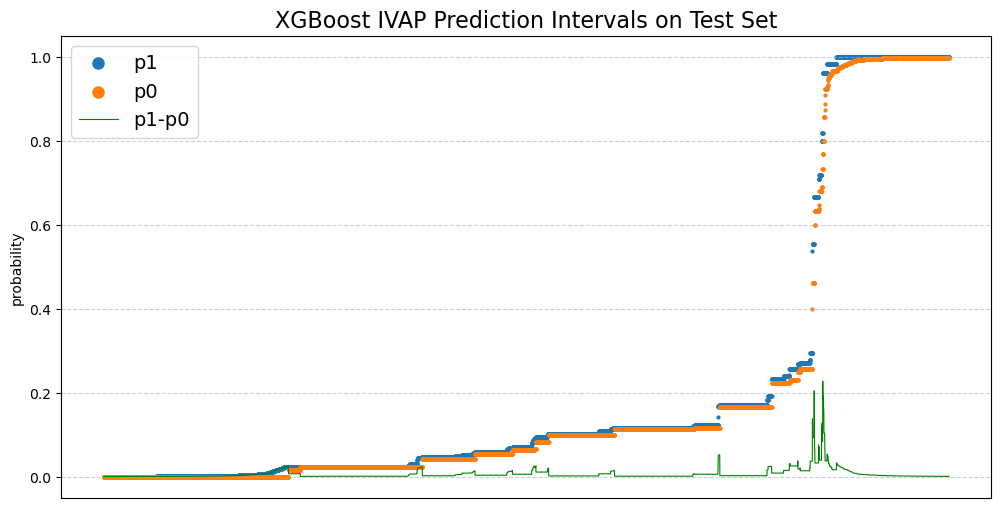

In [ ]:
# xgboost ivap test set
predictions = test.sort_values(by=['xgb_raw_prob'])
predictions = predictions.reset_index()

plt.figure(figsize=(12, 6))
plt.scatter(x=predictions.index,y=predictions["xgb_p1_ivap"],label="p1",s=4)
plt.scatter(x=predictions.index,y=predictions["xgb_p0_ivap"],label="p0",s=4)
plt.plot(predictions.index, predictions["xgb_ivap_width"],label="p1-p0",lw=0.8,color="green")
plt.legend(loc="upper left",fontsize=14, scatterpoints=1, markerscale=4)
plt.ylabel("probability")
plt.title("XGBoost IVAP Prediction Intervals on Test Set", fontsize=16)
plt.xticks([])
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

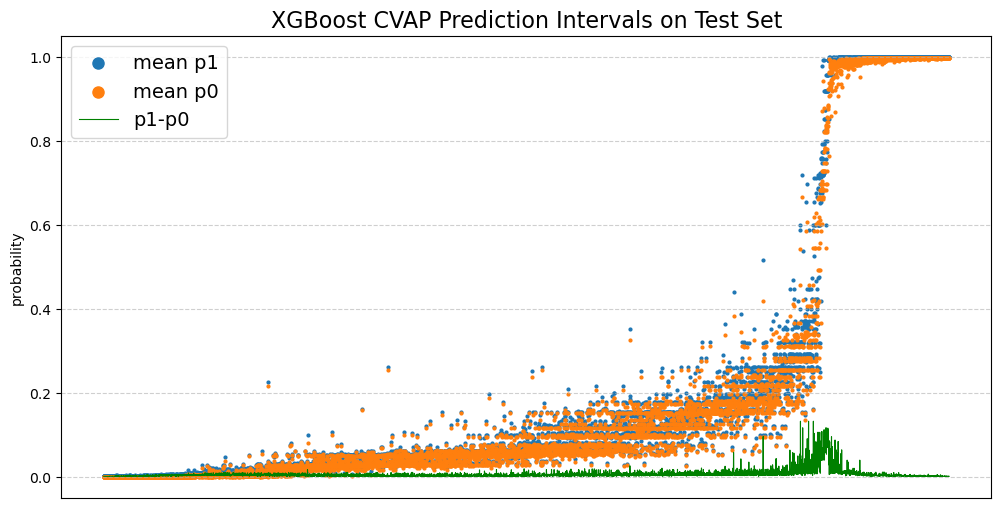

In [194]:
# xgboost cvap test set
predictions = test.sort_values(by=['xgb_raw_prob'])
predictions = predictions.reset_index()

plt.figure(figsize=(12, 6))
plt.scatter(x=predictions.index,y=predictions["xgb_mean_p1_cvap"],label="mean p1",s=4)
plt.scatter(x=predictions.index,y=predictions["xgb_mean_p0_cvap"],label="mean p0",s=4)
plt.plot(predictions.index, predictions["xgb_cvap_width_mean"],label="p1-p0",lw=0.8,color="green")
plt.legend(loc="upper left",fontsize=14, scatterpoints=1, markerscale=4)
plt.ylabel("probability")
plt.title("XGBoost CVAP Prediction Intervals on Test Set", fontsize=16)
plt.xticks([])
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

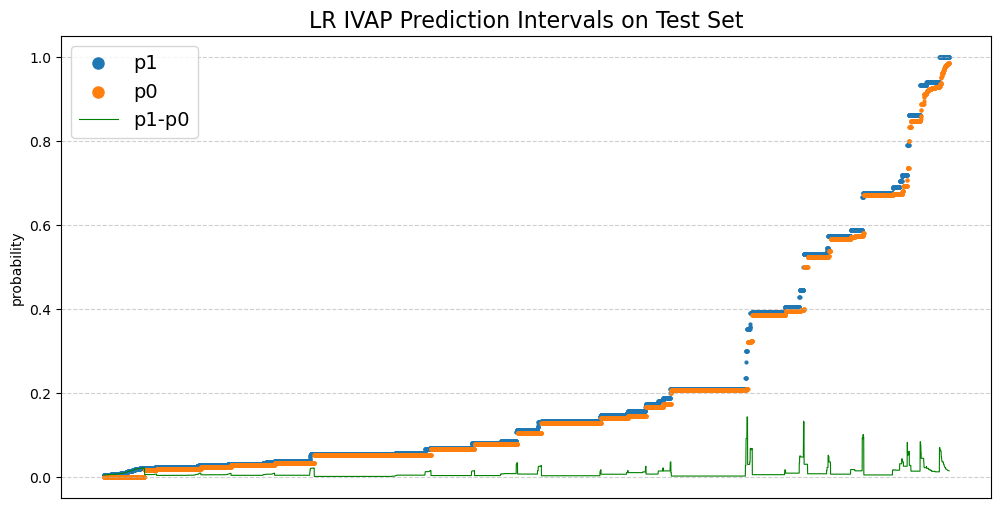

In [195]:
# LR ivap test set
predictions = test.sort_values(by=['lr_raw_prob'])
predictions = predictions.reset_index()

plt.figure(figsize=(12, 6))
plt.scatter(x=predictions.index,y=predictions["lr_p1_ivap"],label="p1",s=4)
plt.scatter(x=predictions.index,y=predictions["lr_p0_ivap"],label="p0",s=4)
plt.plot(predictions.index, predictions["lr_ivap_width"],label="p1-p0",lw=0.8,color="green")
plt.legend(loc="upper left",fontsize=14, scatterpoints=1, markerscale=4)
plt.ylabel("probability")
plt.title("LR IVAP Prediction Intervals on Test Set", fontsize=16)
plt.xticks([])
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


--- Visualizing CDF of Prediction Intervals ---


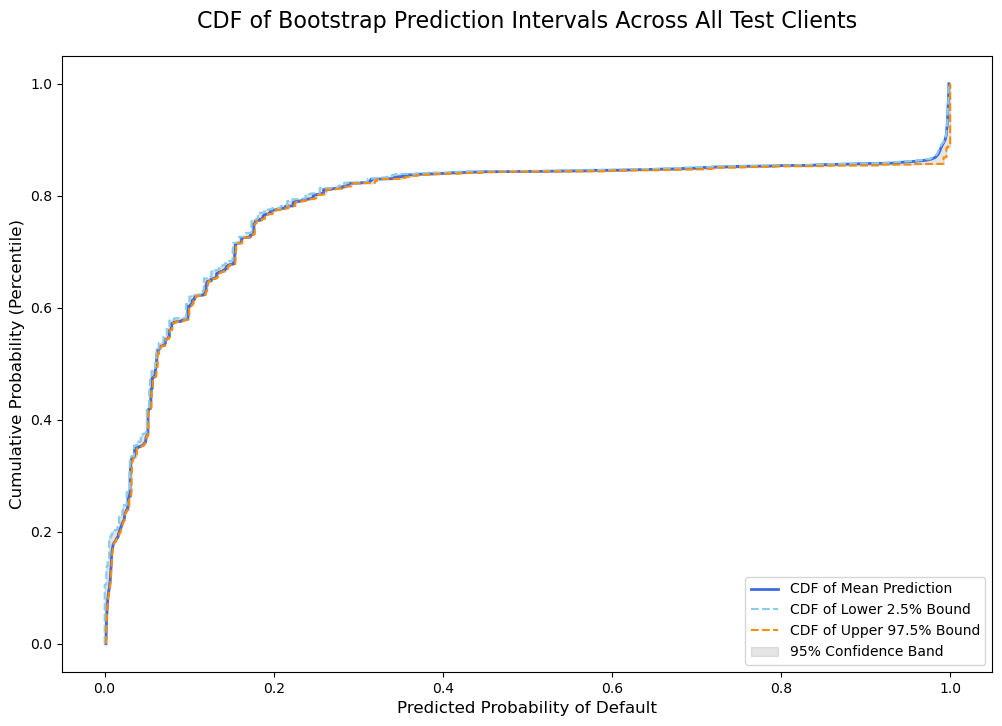

In [ ]:
# We will plot the CDF for the mean predictions, and the lower/upper bounds
mean_probs_sorted = np.sort(test['xgb_venn_cvap'])  # or 'lr_venn_cvap' for Logistic Regression
lower_bounds_sorted = np.sort(test['xgb_mean_p0_cvap'])
upper_bounds_sorted = np.sort(test['xgb_mean_p1_cvap'])

# The y-axis for a CDF is the percentile, from 0 to 1
y_axis = np.linspace(0, 1, len(test))

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the three CDFs
ax.plot(mean_probs_sorted, y_axis, label='CDF of Mean Prediction', color='royalblue', linewidth=2)
ax.plot(lower_bounds_sorted, y_axis, label='CDF of Lower 2.5% Bound', color='skyblue', linestyle='--')
ax.plot(upper_bounds_sorted, y_axis, label='CDF of Upper 97.5% Bound', color='darkorange', linestyle='--')

# Add shading to represent the 95% confidence interval band
ax.fill_betweenx(y_axis, lower_bounds_sorted, upper_bounds_sorted, color='gray', alpha=0.2, label='95% Confidence Band')

ax.set_title('CDF of Bootstrap Prediction Intervals Across All Test Clients', fontsize=16, pad=20)
ax.set_xlabel('Predicted Probability of Default', fontsize=12)
ax.set_ylabel('Cumulative Probability (Percentile)', fontsize=12)
ax.legend(loc='lower right')
plt.show()


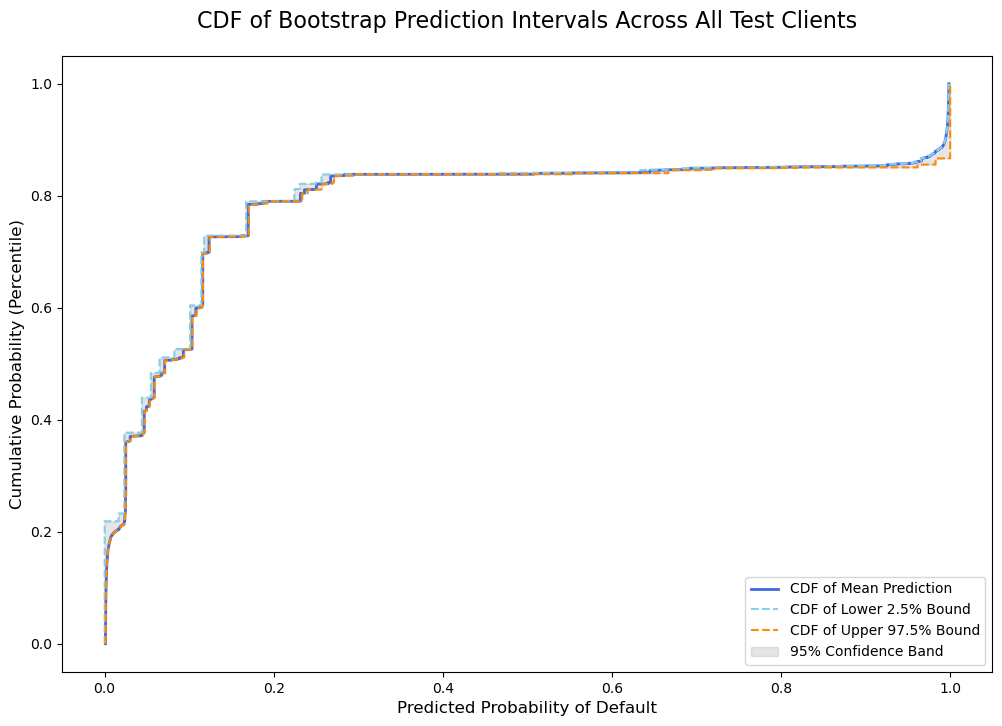

In [200]:
# We will plot the CDF for the mean predictions, and the lower/upper bounds
mean_probs_sorted = np.sort(test['xgb_venn_ivap'])  # or 'lr_venn_cvap' for Logistic Regression
lower_bounds_sorted = np.sort(test['xgb_p0_ivap'])
upper_bounds_sorted = np.sort(test['xgb_p1_ivap'])

# The y-axis for a CDF is the percentile, from 0 to 1
y_axis = np.linspace(0, 1, len(test))

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the three CDFs
ax.plot(mean_probs_sorted, y_axis, label='CDF of Mean Prediction', color='royalblue', linewidth=2)
ax.plot(lower_bounds_sorted, y_axis, label='CDF of Lower 2.5% Bound', color='skyblue', linestyle='--')
ax.plot(upper_bounds_sorted, y_axis, label='CDF of Upper 97.5% Bound', color='darkorange', linestyle='--')

# Add shading to represent the 95% confidence interval band
ax.fill_betweenx(y_axis, lower_bounds_sorted, upper_bounds_sorted, color='gray', alpha=0.2, label='95% Confidence Band')

ax.set_title('CDF of Bootstrap Prediction Intervals Across All Test Clients', fontsize=16, pad=20)
ax.set_xlabel('Predicted Probability of Default', fontsize=12)
ax.set_ylabel('Cumulative Probability (Percentile)', fontsize=12)
ax.legend(loc='lower right')
plt.show()
